*This notebook contains basic analysis of Rep-seq data for Cohort II.*


In [1]:
import os
import re
import time
import sys
from pathlib import Path
sys.path.append("/home/svinogradova/mirpy_repo/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy import stats
from scipy.stats import spearmanr, pearsonr, norm
from statsmodels.stats.multitest import multipletests

In [3]:
from mir.basic.segment_usage import *
from mir.basic.sampling import *

In [4]:
metadata_path = '/projects/fmba_covid/hip_full/metadata.txt'
data_path = '/projects/fmba_covid/publication/hip_full/'

In [5]:
metadata = pd.read_csv(metadata_path, sep='\t')
metadata

,file_name,sample_id,age,race,sex,cmv,hla,..filter..
0,../mixcr/../corr/HIP00110.txt,HIP00110,55.0,NaN,male,-,"HLA-A*03,HLA-A*24,HLA-B*07",corr:2:0.05:all
1,../mixcr/../corr/HIP00169.txt,HIP00169,41.0,NaN,male,-,"HLA-A*01,HLA-A*02,HLA-B*27,HLA-B*37",corr:2:0.05:all
2,../mixcr/../corr/HIP00594.txt,HIP00594,21.0,"caucasian,non-hispanic or latino",male,+,"HLA-A*02,HLA-A*32,HLA-B*07,HLA-B*61",corr:2:0.05:all
3,../mixcr/../corr/HIP00602.txt,HIP00602,45.0,NaN,female,-,"HLA-A*02,HLA-A*11,HLA-B*35,HLA-B*51",corr:2:0.05:all
4,../mixcr/../corr/HIP00614.txt,HIP00614,27.0,"caucasian,non-hispanic or latino",male,-,"HLA-A*03,HLA-A*29,HLA-B*07",corr:2:0.05:all
...,...,...,...,...,...,...,...,...
781,../mixcr/../corr/Keck0116_MC1.txt,Keck0116_MC1,19.0,"asian or pacific islander,non-hispanic or latino",female,-,NaN,corr:2:0.05:all
782,../mixcr/../corr/Keck0117_MC1.txt,Keck0117_MC1,34.0,"caucasian,non-hispanic or latino",male,+,NaN,corr:2:0.05:all
783,../mixcr/../corr/Keck0118_MC1.txt,Keck0118_MC1,28.0,"caucasian,non-hispanic or latino",male,+,NaN,corr:2:0.05:all
784,../mixcr/../corr/Keck0119_MC1.txt,Keck0119_MC1,24.0,"asian or pacific islander,non-hispanic or latino",female,+,NaN,corr:2:0.05:all


Here were create matrixes of gene usage. For Cohort I it was done automatically usying mirpy repo, but it falis to work with really large files.

In [6]:
t0 = time.time()

df_v = pd.DataFrame()
df_j = pd.DataFrame()
df_d = pd.DataFrame()

for file_name in tqdm(os.listdir(data_path)):
    if not file_name.endswith(".gz"):
        with open(os.path.join(data_path, file_name), 'r') as file:
            total_counts = 0
            clonotype_v_dict = {}
            clonotype_d_dict = {}
            clonotype_j_dict = {}

            header = file.readline()        
            for line in file.readlines():
                data = line.strip().split('\t')
                total_counts += int(data[0])
                for clonotype in data[4:7]:
                    clonotype = clonotype.split(',')[0]
                    if 'V' in clonotype:
                        if clonotype in clonotype_v_dict.keys():
                            clonotype_v_dict[clonotype] += 1
                        else:
                            clonotype_v_dict[clonotype] = np.array([1])
                    elif 'D' in clonotype:
                        if clonotype in clonotype_d_dict.keys():
                            clonotype_d_dict[clonotype] += 1
                        else:
                            clonotype_d_dict[clonotype] = np.array([1])
                    elif 'J' in clonotype:
                        if clonotype in clonotype_j_dict.keys():
                            clonotype_j_dict[clonotype] += 1
                        else:
                            clonotype_j_dict[clonotype] = np.array([1])

            clonotype_v_dict['id'] = file_name
            clonotype_d_dict['id'] = file_name
            clonotype_j_dict['id'] = file_name


            if total_counts >= 10000:
                df_v = pd.concat([df_v, pd.DataFrame(clonotype_v_dict)]).sort_index(axis=1, ascending=False)
                df_d = pd.concat([df_d, pd.DataFrame(clonotype_d_dict)]).sort_index(axis=1, ascending=False)
                df_j = pd.concat([df_j, pd.DataFrame(clonotype_j_dict)]).sort_index(axis=1, ascending=False)
                
print((time.time() - t0)/60)

100%|██████████| 1572/1572 [21:52<00:00,  1.20it/s]

21.87038808663686


In [8]:
df_v

,id,TRBV9,TRBV8-2,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,...,TRBV1,TRAV9-2,TRAV9-1,TRAV33,TRAV3,TRAV29DV5,TRAV23DV6,TRAV20,TRAV16,TRAV14DV4
0,HIP14174.txt,12041,1.0,12834,8924,1495,3656,222,1362,3986,...,772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,HIP13142.txt,13100,2.0,17700,4995,1381,3449,247,331,7393,...,999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,HIP02928.txt,13669,NaN,13258,4246,1279,3606,230,472,5543,...,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,HIP14096.txt,3872,NaN,6277,1789,587,1345,81,494,1088,...,267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,HIP01765.txt,2456,2.0,2678,903,272,664,45,92,1149,...,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,HIP13951.txt,10035,1.0,14167,4478,1459,3591,302,1480,4803,...,819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,HIP14039.txt,7310,NaN,8118,2667,903,2080,162,301,5311,...,342,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
0,HIP13627.txt,7746,NaN,9152,2753,792,2187,102,218,4353,...,234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,HIP17698.txt,6998,1.0,12968,1958,743,2129,155,944,2736,...,464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


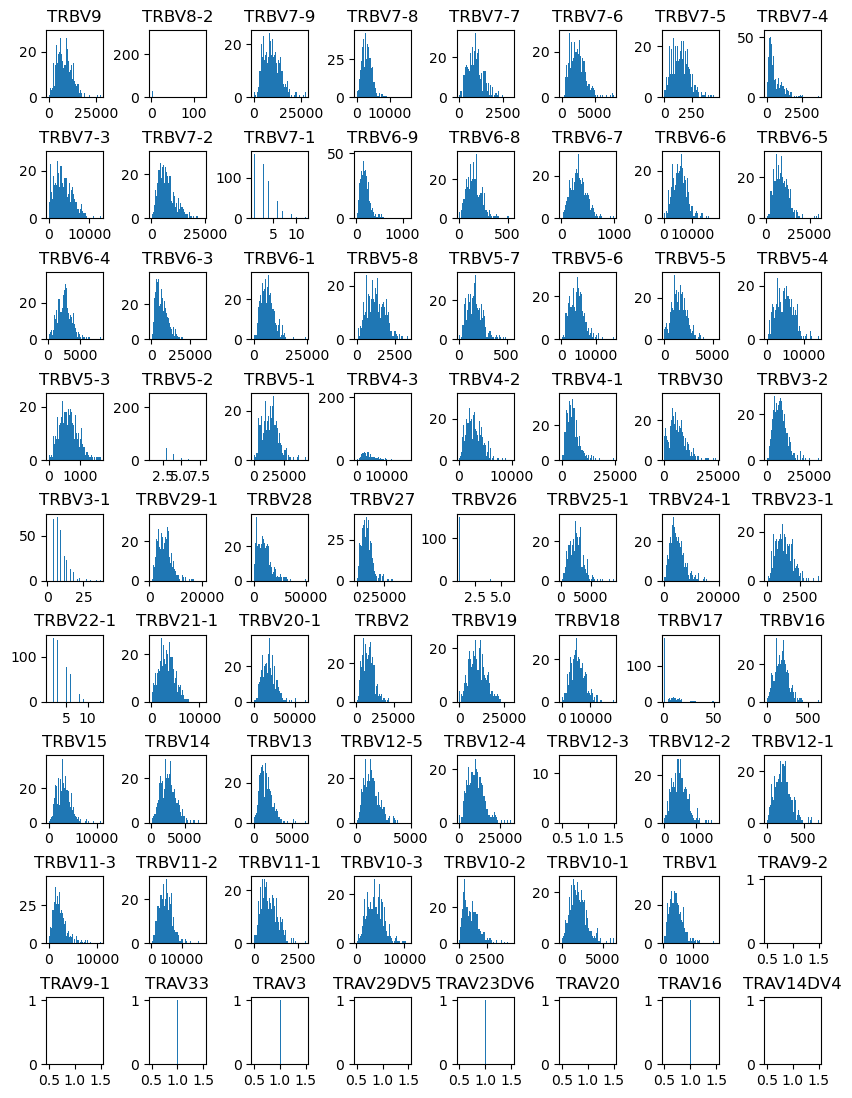

In [20]:
plt.figure(figsize=(10,15))

for i, column in enumerate(df_v.drop(['id'], axis=1).columns):
    plt.subplot(10, 8, i+1)
    plt.hist(x=df_v[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()

Then delete unneccessory genes, like pseudo-genes or those which were poorly sequenced.

In [30]:
df_v_clean = df_v.drop(["TRAV9-2", "TRBV8-2", "TRBV7-1", "TRAV9-1", "TRBV5-2", "TRBV26", "TRBV3-1", "TRAV33", "TRAV3", "TRAV29DV5", "TRAV23DV6", 
                        "TRAV20", "TRAV16", "TRAV14DV4", "TRBV12-3", "TRBV22-1"], axis=1)

In [31]:
df_v_clean

,id,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,...,TRBV12-4,TRBV12-2,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1
0,HIP14174.txt,12041,12834,8924,1495,3656,222,1362,3986,8733,...,15590,786,358.0,2036,5356,998,5989,1898,2922,772
0,HIP13142.txt,13100,17700,4995,1381,3449,247,331,7393,9454,...,15863,738,370.0,2061,8045,1199,6468,2395,4424,999
0,HIP02928.txt,13669,13258,4246,1279,3606,230,472,5543,8092,...,15941,680,305.0,2677,6958,1335,3946,1963,3103,700
0,HIP14096.txt,3872,6277,1789,587,1345,81,494,1088,5300,...,7147,313,131.0,620,1924,310,2611,984,1366,267
0,HIP01765.txt,2456,2678,903,272,664,45,92,1149,1967,...,2845,154,61.0,461,1310,335,1171,319,532,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,HIP13951.txt,10035,14167,4478,1459,3591,302,1480,4803,10376,...,13527,962,403.0,2972,9725,1357,7417,3060,4337,819
0,HIP14039.txt,7310,8118,2667,903,2080,162,301,5311,5228,...,7466,405,175.0,2145,3999,1000,3463,738,1713,342
0,HIP13627.txt,7746,9152,2753,792,2187,102,218,4353,7633,...,9466,340,152.0,1297,3350,886,3639,455,1006,234
0,HIP17698.txt,6998,12968,1958,743,2129,155,944,2736,8720,...,9832,525,258.0,2151,6621,945,4279,1578,2547,464


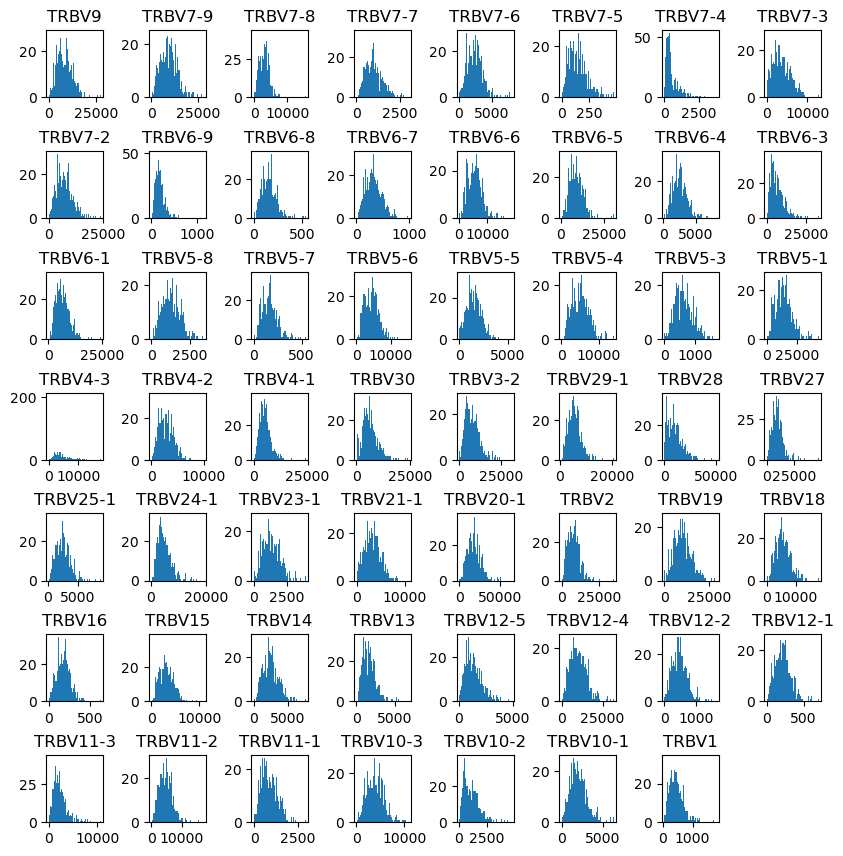

In [27]:
plt.figure(figsize=(10,15))

for i, column in enumerate(df_v_clean.drop(['id'], axis=1).columns):
    plt.subplot(10, 8, i+1)
    plt.hist(x=df_v_clean[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()

In [9]:
df_d

,id,TRDD3,TRBD2,TRBD1
0,HIP14174.txt,NaN,119885,146425
0,HIP13142.txt,NaN,144192,147370
0,HIP02928.txt,NaN,104951,135103
0,HIP14096.txt,NaN,47842,64785
0,HIP01765.txt,NaN,24310,28170
...,...,...,...,...
0,HIP13951.txt,NaN,151201,144231
0,HIP14039.txt,NaN,66106,72710
0,HIP13627.txt,NaN,60553,88764
0,HIP17698.txt,NaN,90705,91668


In [10]:
df_j

,id,TRBJ2-7,TRBJ2-6,TRBJ2-5,TRBJ2-4,TRBJ2-3,TRBJ2-2P,TRBJ2-2,TRBJ2-1,TRBJ1-6,TRBJ1-5,TRBJ1-4,TRBJ1-3,TRBJ1-2,TRBJ1-1,TRAJ52,TRAJ4
0,HIP14174.txt,63634,5474,29509,4377,33280,NaN,24499,42220,9888,28377,15028,10858,35531,42584,NaN,NaN
0,HIP13142.txt,78784,6574,29457,5862,34717,NaN,26806,53357,4692,30175,16262,11671,39283,47026,NaN,NaN
0,HIP02928.txt,48217,4722,25876,4204,31109,1.0,20675,34080,14452,21946,13403,10617,40640,45697,NaN,NaN
0,HIP14096.txt,24707,2863,12109,1604,12868,NaN,9309,16871,4793,12041,6740,5027,19455,22506,NaN,NaN
0,HIP01765.txt,13099,1199,5743,1081,6387,NaN,4981,9360,2492,5315,2824,2125,6594,7717,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,HIP13951.txt,78283,7245,31631,5976,41491,NaN,27580,59305,4569,27721,15284,11052,35847,43482,NaN,NaN
0,HIP14039.txt,33231,3161,16781,3235,19296,NaN,13381,24958,6472,13475,7341,5861,17561,18221,NaN,1.0
0,HIP13627.txt,24990,2888,14678,2317,17158,NaN,12257,20208,9902,17735,9964,8060,26369,29674,NaN,NaN
0,HIP17698.txt,47444,6196,19867,5753,23596,NaN,16089,36803,4637,17071,9389,7378,21838,25430,NaN,NaN


In [6]:
metadata["id"] = metadata.file_name.str.split('/').str[-1]
metadata

,file_name,sample_id,age,race,sex,cmv,hla,..filter..,id
0,../mixcr/../corr/HIP00110.txt,HIP00110,55.0,NaN,male,-,"HLA-A*03,HLA-A*24,HLA-B*07",corr:2:0.05:all,HIP00110.txt
1,../mixcr/../corr/HIP00169.txt,HIP00169,41.0,NaN,male,-,"HLA-A*01,HLA-A*02,HLA-B*27,HLA-B*37",corr:2:0.05:all,HIP00169.txt
2,../mixcr/../corr/HIP00594.txt,HIP00594,21.0,"caucasian,non-hispanic or latino",male,+,"HLA-A*02,HLA-A*32,HLA-B*07,HLA-B*61",corr:2:0.05:all,HIP00594.txt
3,../mixcr/../corr/HIP00602.txt,HIP00602,45.0,NaN,female,-,"HLA-A*02,HLA-A*11,HLA-B*35,HLA-B*51",corr:2:0.05:all,HIP00602.txt
4,../mixcr/../corr/HIP00614.txt,HIP00614,27.0,"caucasian,non-hispanic or latino",male,-,"HLA-A*03,HLA-A*29,HLA-B*07",corr:2:0.05:all,HIP00614.txt
...,...,...,...,...,...,...,...,...,...
781,../mixcr/../corr/Keck0116_MC1.txt,Keck0116_MC1,19.0,"asian or pacific islander,non-hispanic or latino",female,-,NaN,corr:2:0.05:all,Keck0116_MC1.txt
782,../mixcr/../corr/Keck0117_MC1.txt,Keck0117_MC1,34.0,"caucasian,non-hispanic or latino",male,+,NaN,corr:2:0.05:all,Keck0117_MC1.txt
783,../mixcr/../corr/Keck0118_MC1.txt,Keck0118_MC1,28.0,"caucasian,non-hispanic or latino",male,+,NaN,corr:2:0.05:all,Keck0118_MC1.txt
784,../mixcr/../corr/Keck0119_MC1.txt,Keck0119_MC1,24.0,"asian or pacific islander,non-hispanic or latino",female,+,NaN,corr:2:0.05:all,Keck0119_MC1.txt


In [39]:
df_v = pd.read_csv("df_v_unnorm.csv")
df_v_clean = df_v.drop(["TRAV9-2", "TRBV8-2", "TRBV7-1", "TRAV9-1", "TRBV5-2", "TRBV26", "TRBV3-1", "TRAV33", "TRAV3", "TRAV29DV5", "TRAV23DV6", 
                        "TRAV20", "TRAV16", "TRAV14DV4", "TRBV12-3", "TRBV22-1", "Unnamed: 0"], axis=1)

Now we need to perform batch normalization between Hip and keck batches. 

In [18]:
df_j = pd.read_csv("df_j_unnorm.csv")
df_j.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785 entries, 0 to 784
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  785 non-null    int64  
 1   id          785 non-null    object 
 2   TRBJ2-7     785 non-null    int64  
 3   TRBJ2-6     785 non-null    int64  
 4   TRBJ2-5     785 non-null    int64  
 5   TRBJ2-4     785 non-null    int64  
 6   TRBJ2-3     785 non-null    int64  
 7   TRBJ2-2P    13 non-null     float64
 8   TRBJ2-2     785 non-null    int64  
 9   TRBJ2-1     785 non-null    int64  
 10  TRBJ1-6     785 non-null    int64  
 11  TRBJ1-5     785 non-null    int64  
 12  TRBJ1-4     785 non-null    int64  
 13  TRBJ1-3     785 non-null    int64  
 14  TRBJ1-2     785 non-null    int64  
 15  TRBJ1-1     785 non-null    int64  
 16  TRAJ52      4 non-null      float64
 17  TRAJ4       5 non-null      float64
dtypes: float64(3), int64(14), object(1)
memory usage: 110.5+ KB


In [21]:
df_j_clean = df_j.drop(["TRBJ2-2P", "TRAJ52", "TRAJ4", "Unnamed: 0"], axis=1)

In [12]:
df_v_norm = NormalizedSegmentUsageTable(segment_usage_matrix=df_v.drop(['id'], axis=1), metadata=metadata).preprocess_usage_table(df_v.drop(['id'], axis=1))
df_v_norm['id'] = df_v['id']
df_d_norm = NormalizedSegmentUsageTable(segment_usage_matrix=df_d.drop(['id'], axis=1), metadata=metadata).preprocess_usage_table(df_d.drop(['id'], axis=1))
df_d_norm['id'] = df_d['id']
df_j_norm = NormalizedSegmentUsageTable(segment_usage_matrix=df_j.drop(['id'], axis=1), metadata=metadata).preprocess_usage_table(df_j.drop(['id'], axis=1))
df_j_norm['id'] = df_j['id']

In [13]:
df_v_norm

,TRBV9,TRBV8-2,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,...,TRBV10-1,TRBV1,TRAV9-2,TRAV9-1,TRAV3,TRAV29DV5,TRAV23DV6,TRAV20,TRAV14DV4,id
0,0.034875,0.000003,0.037172,0.025847,0.004330,0.010589,0.000643,0.003945,0.011545,0.025294,...,0.008463,0.002236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIP14174.txt
0,0.034056,0.000005,0.046014,0.012985,0.003590,0.008966,0.000642,0.000860,0.019219,0.024577,...,0.011501,0.002597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIP13142.txt
0,0.043306,NaN,0.042004,0.013452,0.004052,0.011424,0.000729,0.001495,0.017561,0.025637,...,0.009831,0.002218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIP02928.txt
0,0.025661,NaN,0.041599,0.011856,0.003890,0.008914,0.000537,0.003274,0.007210,0.035124,...,0.009053,0.001769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIP14096.txt
0,0.035637,0.000029,0.038858,0.013103,0.003947,0.009635,0.000653,0.001335,0.016672,0.028542,...,0.007719,0.001799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIP01765.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.025766,0.000003,0.036375,0.011498,0.003746,0.009220,0.000775,0.003800,0.012332,0.026642,...,0.011136,0.002103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIP13951.txt
0,0.039951,NaN,0.044367,0.014576,0.004935,0.011368,0.000885,0.001645,0.029026,0.028572,...,0.009362,0.001869,NaN,NaN,0.000005,NaN,NaN,NaN,NaN,HIP14039.txt
0,0.039480,NaN,0.046646,0.014032,0.004037,0.011147,0.000520,0.001111,0.022187,0.038904,...,0.005127,0.001193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIP13627.txt
0,0.028978,0.000004,0.053700,0.008108,0.003077,0.008816,0.000642,0.003909,0.011330,0.036109,...,0.010547,0.001921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HIP17698.txt


In [14]:
df_d_norm

,TRDD3,TRBD2,TRBD1,id
0,NaN,0.450171,0.549829,HIP14174.txt
0,NaN,0.494550,0.505450,HIP13142.txt
0,NaN,0.437197,0.562803,HIP02928.txt
0,NaN,0.424783,0.575217,HIP14096.txt
0,NaN,0.463224,0.536776,HIP01765.txt
...,...,...,...,...
0,NaN,0.511796,0.488204,HIP13951.txt
0,NaN,0.476213,0.523787,HIP14039.txt
0,NaN,0.405533,0.594467,HIP13627.txt
0,NaN,0.497360,0.502640,HIP17698.txt


In [15]:
df_j_norm

,TRBJ2-7,TRBJ2-6,TRBJ2-5,TRBJ2-4,TRBJ2-3,TRBJ2-2P,TRBJ2-2,TRBJ2-1,TRBJ1-6,TRBJ1-5,TRBJ1-4,TRBJ1-3,TRBJ1-2,TRBJ1-1,TRAJ52,TRAJ4,id
0,0.184308,0.015855,0.085469,0.012677,0.096391,NaN,0.070958,0.122285,0.028639,0.082190,0.043527,0.031449,0.102911,0.123339,NaN,NaN,HIP14174.txt
0,0.204811,0.017090,0.076578,0.015239,0.090252,NaN,0.069686,0.138710,0.012198,0.078445,0.042276,0.030341,0.102122,0.122252,NaN,NaN,HIP13142.txt
0,0.152760,0.014960,0.081980,0.013319,0.098559,0.000003,0.065502,0.107971,0.045786,0.069529,0.042463,0.033637,0.128755,0.144776,NaN,NaN,HIP02928.txt
0,0.163739,0.018974,0.080249,0.010630,0.085279,NaN,0.061693,0.111808,0.031764,0.079798,0.044667,0.033315,0.128932,0.149152,NaN,NaN,HIP14096.txt
0,0.190069,0.017398,0.083332,0.015686,0.092677,NaN,0.072275,0.135816,0.036159,0.077122,0.040977,0.030834,0.095680,0.111975,NaN,NaN,HIP01765.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.201001,0.018602,0.081216,0.015344,0.106533,NaN,0.070815,0.152273,0.011731,0.071177,0.039243,0.028377,0.092041,0.111645,NaN,NaN,HIP13951.txt
0,0.181615,0.017276,0.091712,0.017680,0.105457,NaN,0.073130,0.136401,0.035371,0.073644,0.040120,0.032032,0.095975,0.099582,NaN,0.000005,HIP14039.txt
0,0.127370,0.014720,0.074811,0.011809,0.087452,NaN,0.062472,0.102997,0.050469,0.090392,0.050785,0.041081,0.134399,0.151244,NaN,NaN,HIP13627.txt
0,0.196463,0.025657,0.082268,0.023823,0.097710,NaN,0.066624,0.152399,0.019202,0.070690,0.038879,0.030552,0.090430,0.105304,NaN,NaN,HIP17698.txt


# V genes

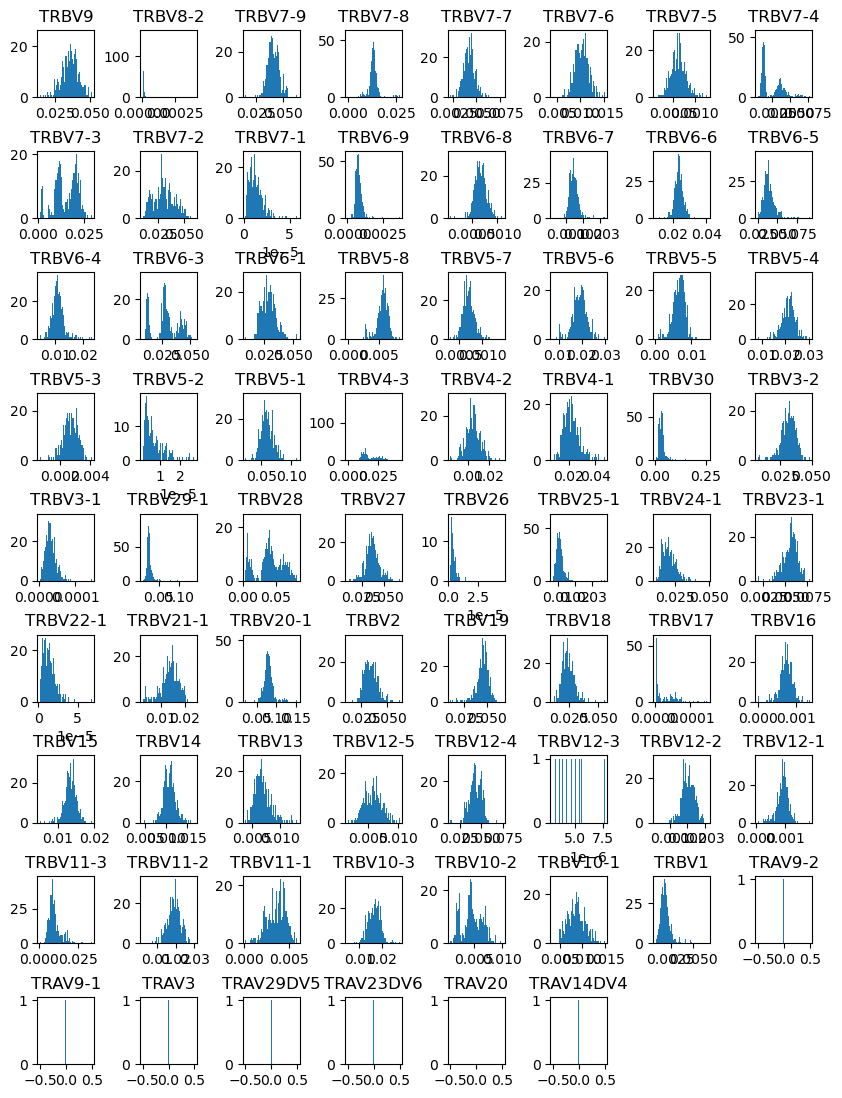

In [180]:
plt.figure(figsize=(10,15))

for i, column in enumerate(df_v_norm.drop(['id'], axis=1).columns):
    plt.subplot(10, 8, i+1)
    plt.hist(x=df_v_norm[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()

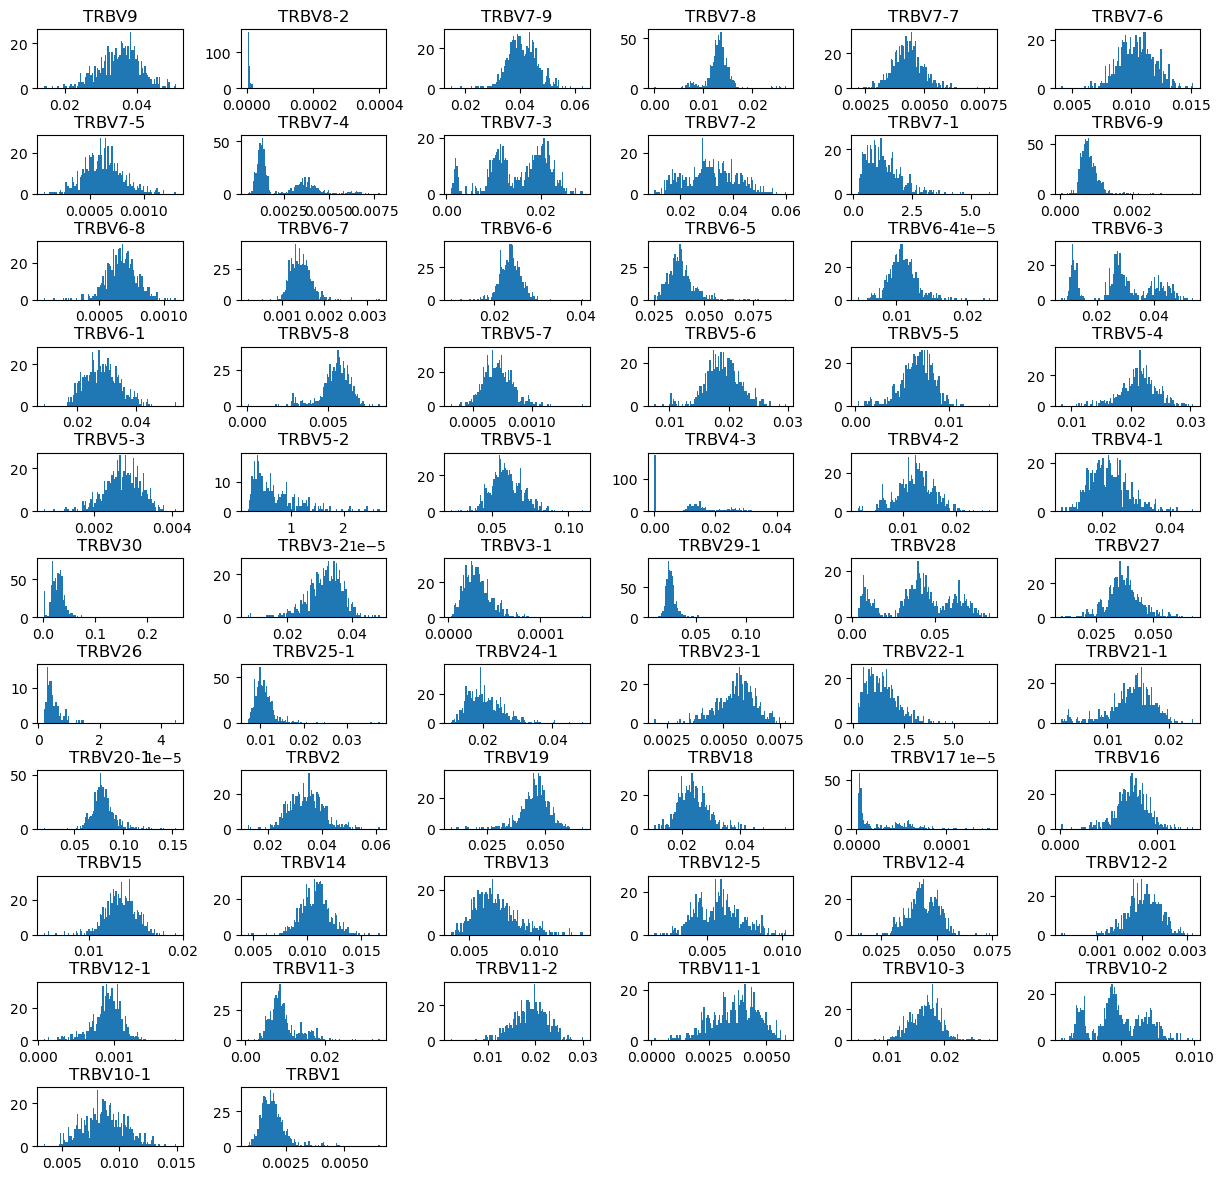

In [30]:
df_v_norm_filtered = df_v_norm.copy()
df_v_norm_filtered = df_v_norm_filtered.drop(['TRBV12-3', 'TRAV9-2', 'TRAV9-1', 'TRAV3',
                                             'TRAV29DV5', 'TRAV23DV6', 'TRAV20', 'TRAV14DV4'], axis=1)

plt.figure(figsize=(15,20))

for i, column in enumerate(df_v_norm_filtered.drop(['id'], axis=1).columns):
    plt.subplot(15, 6, i+1)
    plt.hist(x=df_v_norm_filtered[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()

# D genes

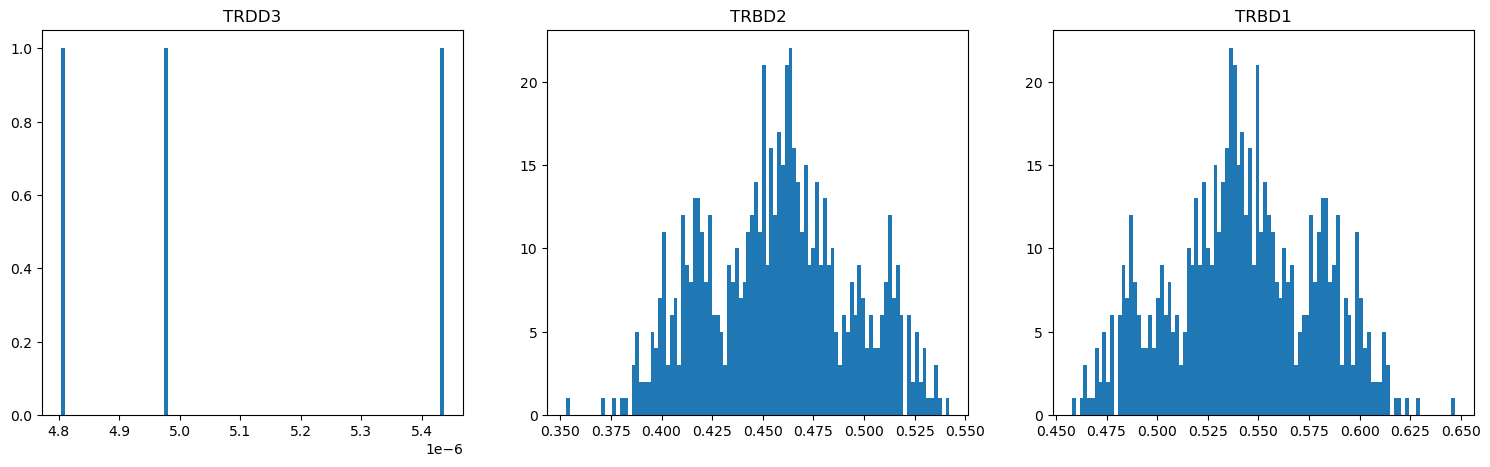

In [189]:
plt.figure(figsize=(25,5))

for i, column in enumerate(df_d_norm.drop(['id'], axis=1).columns):
    plt.subplot(1, 4, i+1)
    plt.hist(x=df_d_norm[column], bins=100)
    plt.title(f'{column}') 
plt.show()

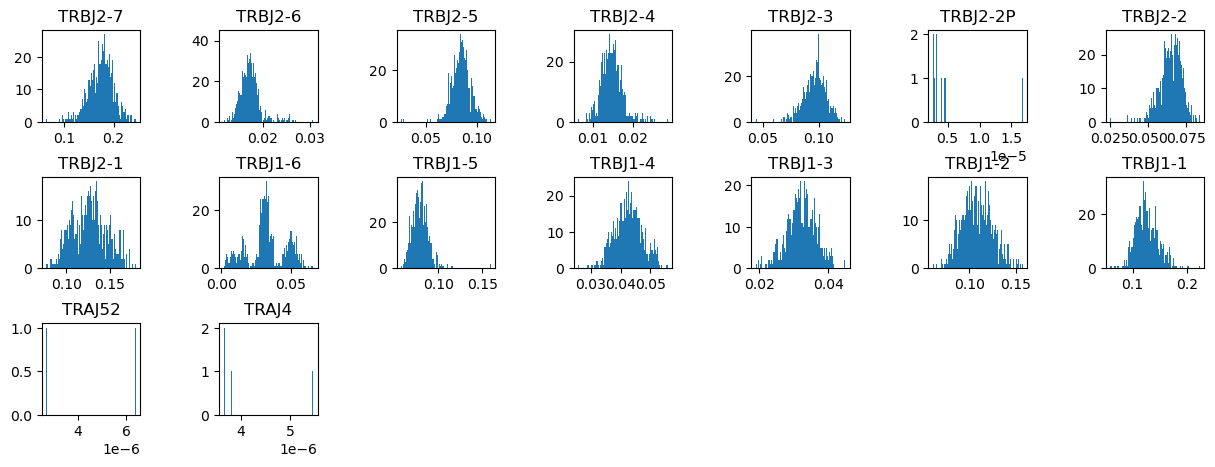

In [35]:
plt.figure(figsize=(15,5))

for i, column in enumerate(df_j_norm.drop(['id'], axis=1).columns):
    plt.subplot(3, 7, i+1)
    plt.hist(x=df_j_norm[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.8, hspace=0.6)
plt.show()

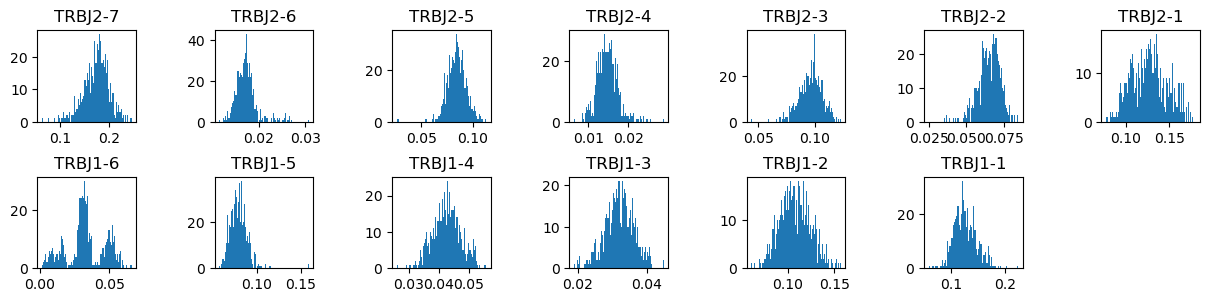

In [36]:
df_j_norm_filtered = df_j_norm.copy()
df_j_norm_filtered = df_j_norm_filtered.drop(['TRBJ2-2P', 'TRAJ52', 'TRAJ4'], axis=1)

plt.figure(figsize=(15,5))

for i, column in enumerate(df_j_norm_filtered.drop(['id'], axis=1).columns):
    plt.subplot(3, 7, i+1)
    plt.hist(x=df_j_norm_filtered[column], bins=100)
    plt.title(f'{column}') 
plt.subplots_adjust(wspace=0.8, hspace=0.6)
plt.show()

# Cluster maps

## V genes

In [225]:
df_v_norm_no_na = df_v_norm.dropna(axis=1)

In [37]:
df_v_norm_0 = df_v_norm.fillna(0)

In [224]:
print(f'Genes to drop: {df_v_norm.columns[list(df_v_norm.isna().any())]}')

Genes to drop: Index(['TRBV8-2', 'TRBV7-1', 'TRBV5-2', 'TRBV4-3', 'TRBV3-1', 'TRBV26',
       'TRBV22-1', 'TRBV17', 'TRBV16', 'TRBV12-3', 'TRBV12-1', 'TRAV9-2',
       'TRAV9-1', 'TRAV3', 'TRAV29DV5', 'TRAV23DV6', 'TRAV20', 'TRAV14DV4'],
      dtype='object')


<Figure size 1500x1500 with 0 Axes>

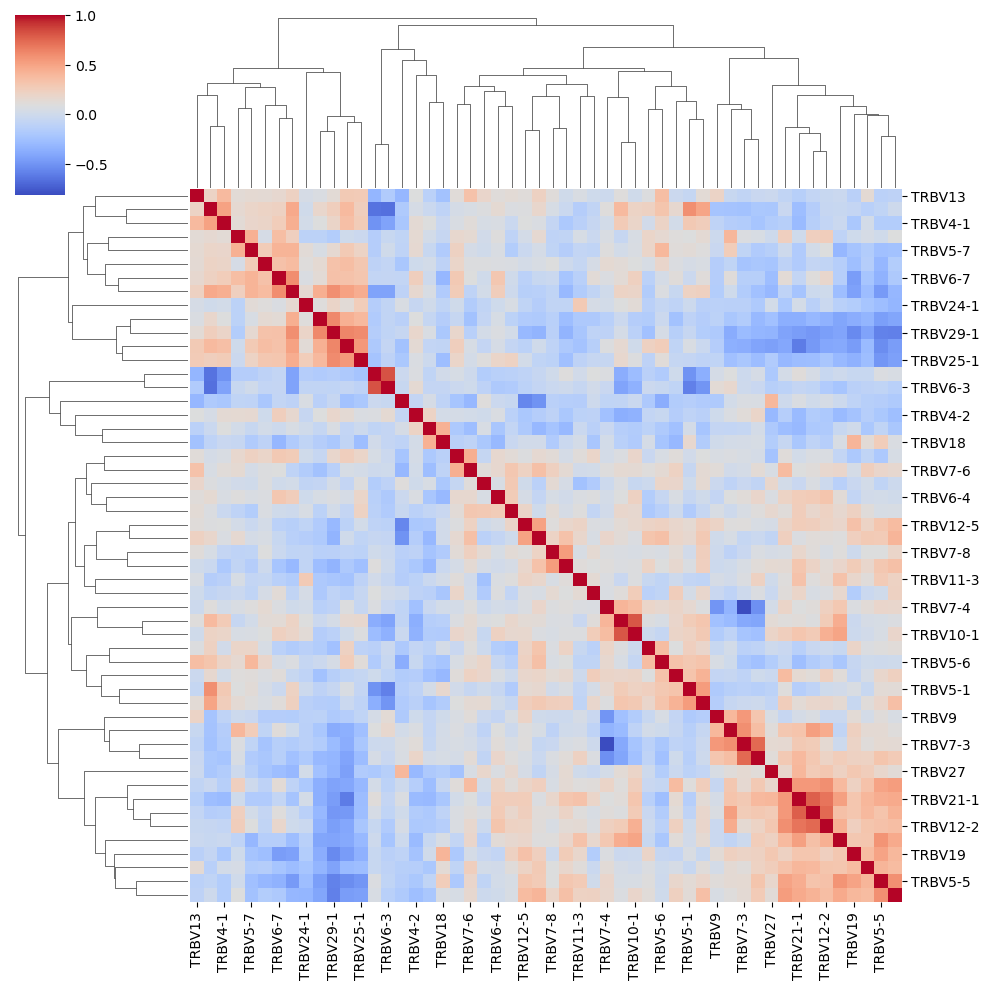

In [226]:
plt.figure(figsize=(15,15))

corr_v_matrix = df_v_norm_no_na.drop(['id'], axis=1).corr() 
sns.clustermap(corr_v_matrix, cmap= 'coolwarm');

<Figure size 1500x1500 with 0 Axes>

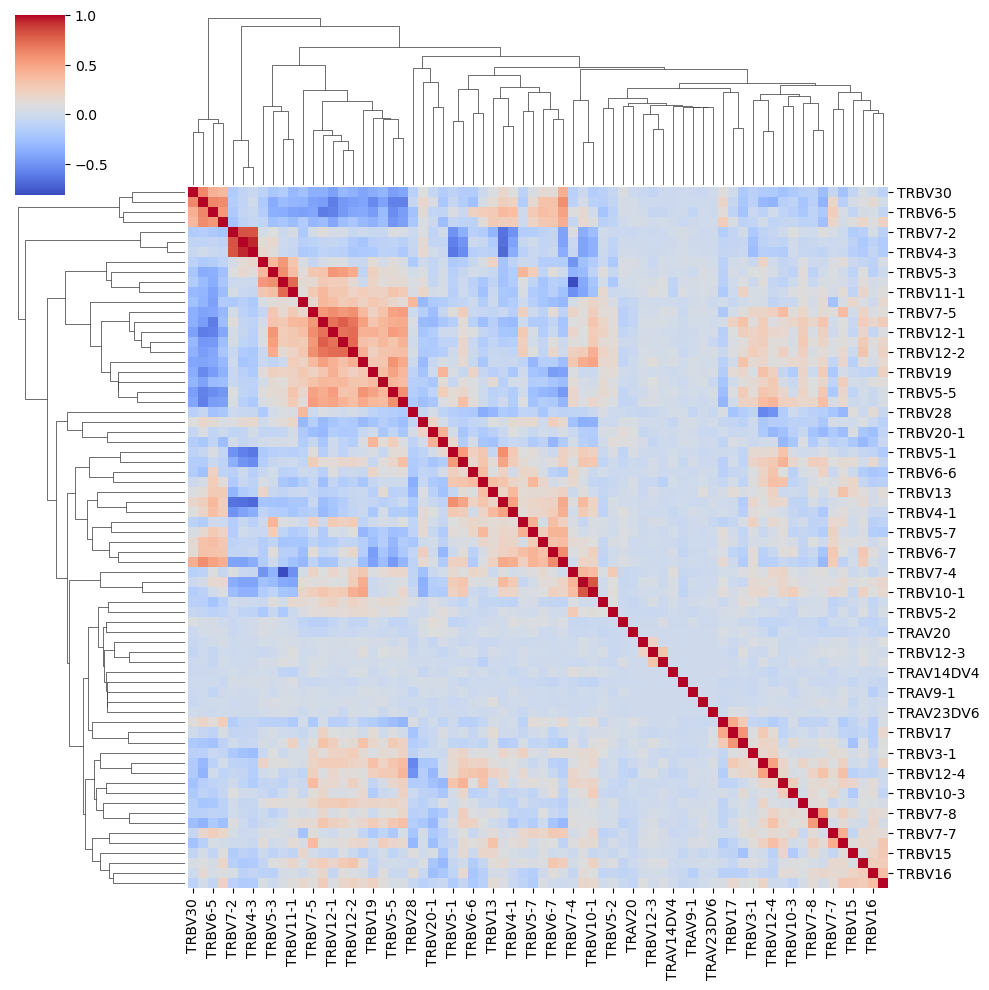

In [38]:
plt.figure(figsize=(15,15))

corr_v_matrix = df_v_norm_0.drop(['id'], axis=1).corr() 
sns.clustermap(corr_v_matrix, cmap= 'coolwarm');

# J genes

In [43]:
df_j_norm_0 = df_j_norm.fillna(0)

In [229]:
df_j_norm_no_na = df_j_norm.dropna(axis=1)
print(f'Genes to drop: {df_j_norm.columns[list(df_j_norm.isna().any())]}')

Genes to drop: Index(['TRBJ2-2P', 'TRAJ52', 'TRAJ4'], dtype='object')


<Figure size 1500x1500 with 0 Axes>

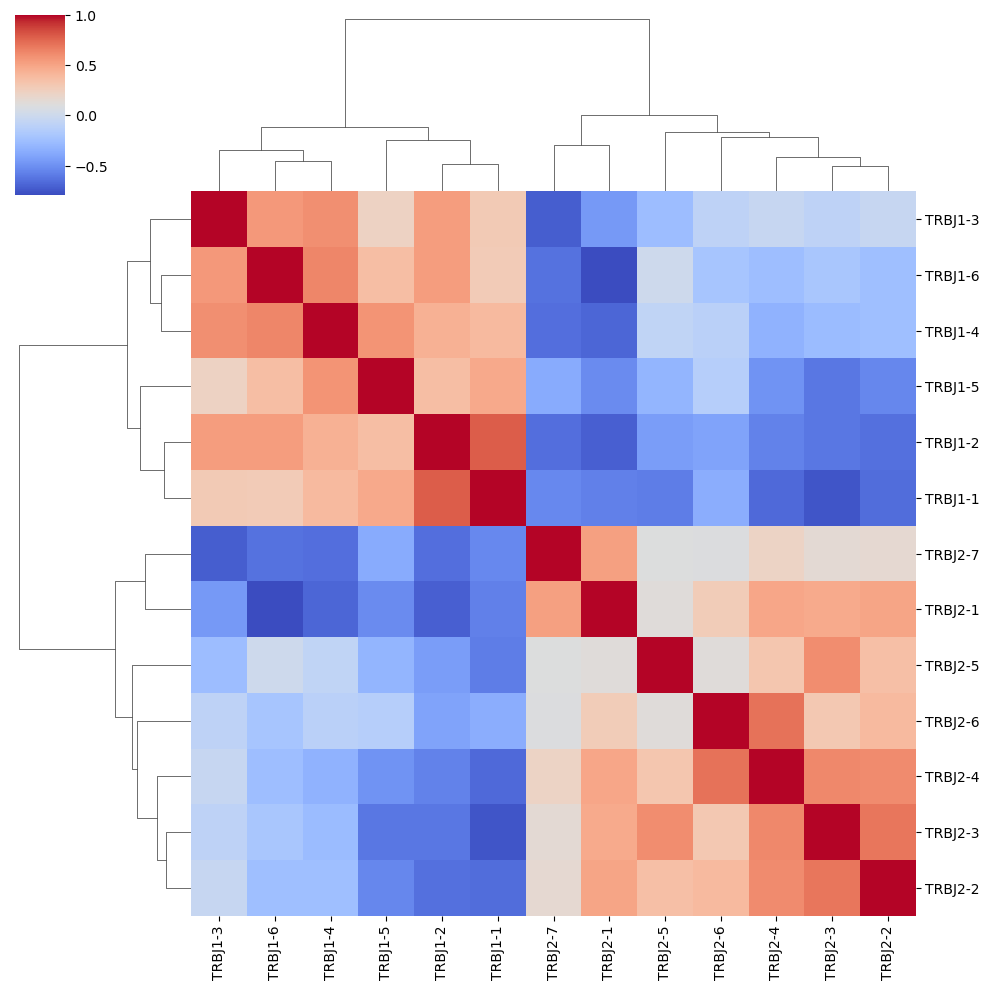

In [230]:
plt.figure(figsize=(15,15))

corr_v_matrix = df_j_norm_no_na.drop(['id'], axis=1).corr() 
sns.clustermap(corr_v_matrix, cmap= 'coolwarm');

<Figure size 1500x1500 with 0 Axes>

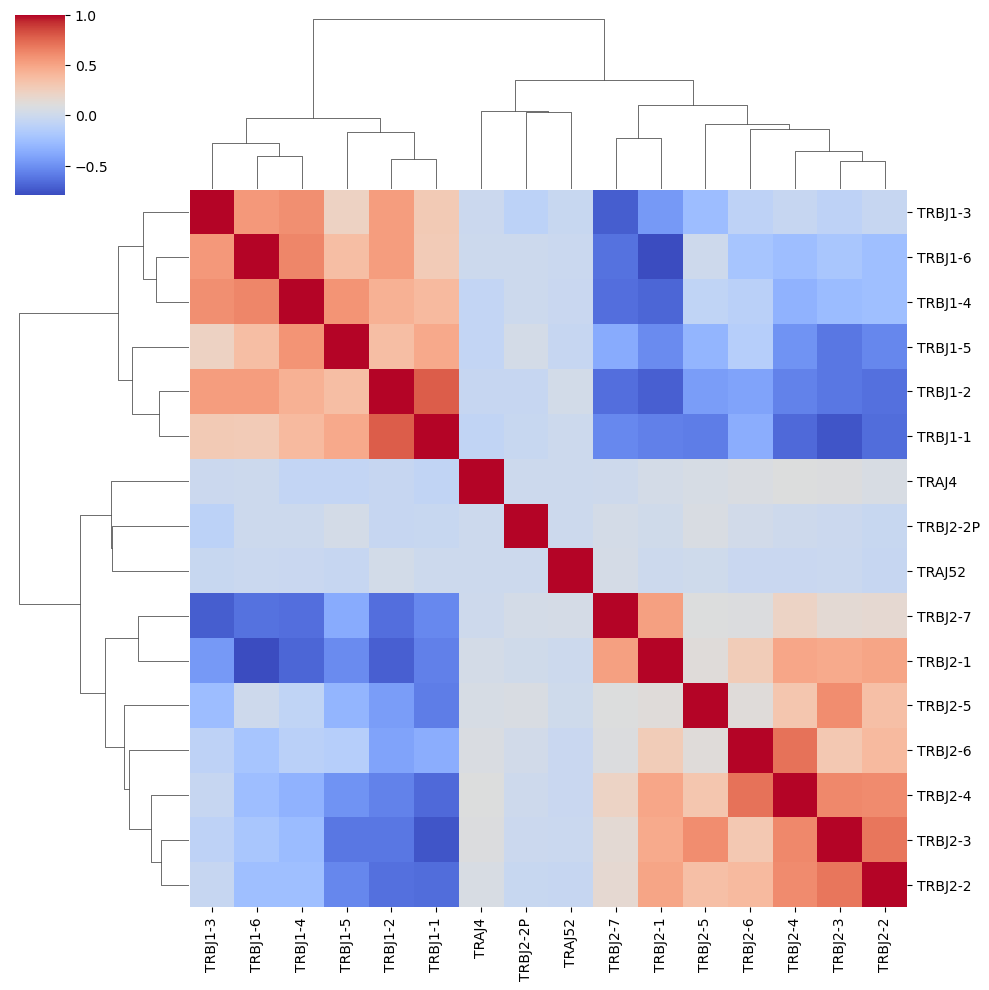

In [45]:
plt.figure(figsize=(15,15))

corr_j_matrix = df_j_norm_0.drop(['id'], axis=1).corr() 
sns.clustermap(corr_j_matrix, cmap= 'coolwarm');

# V vs J genes

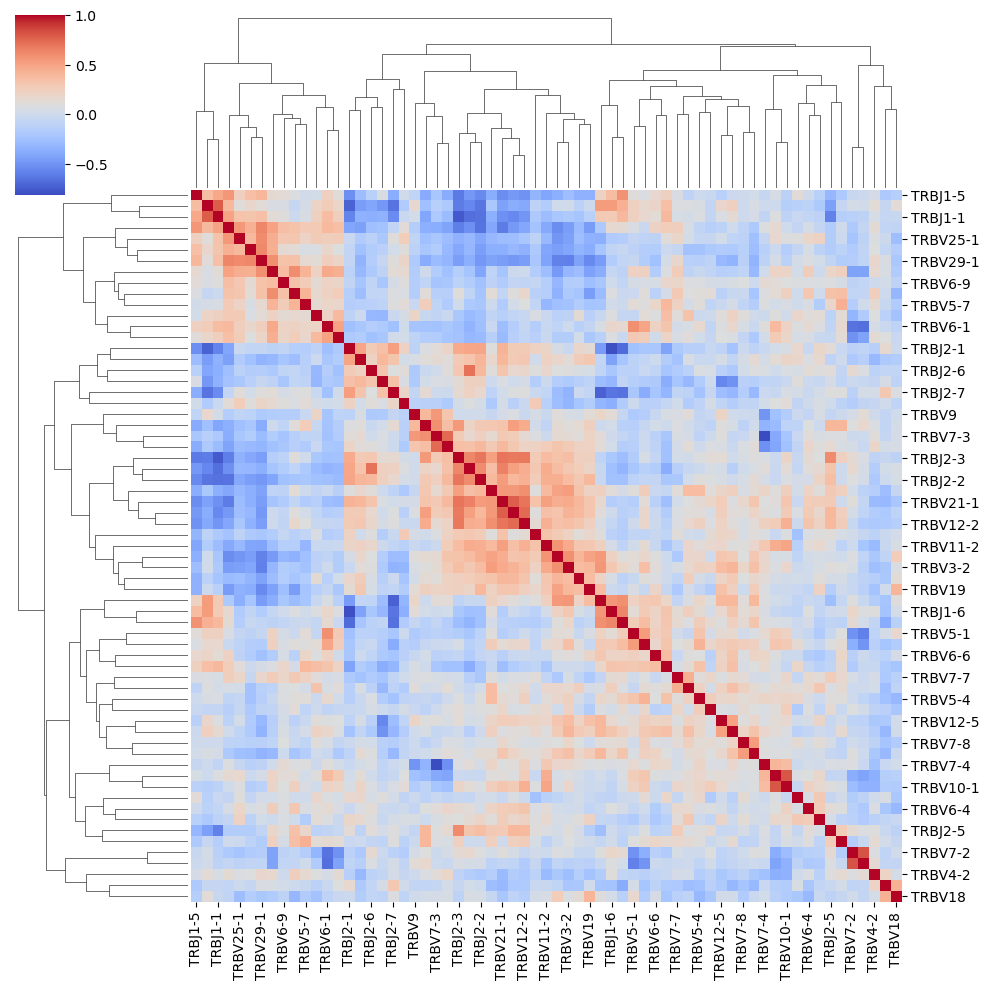

In [232]:
v_j_merged = pd.concat([df_j_norm_no_na.drop(['id'], axis=1), df_v_norm_no_na.drop(['id'], axis=1)], axis=1)

corr_v_j_matrix = v_j_merged.corr()
sns.clustermap(corr_v_j_matrix, cmap= 'coolwarm') 

plt.show()

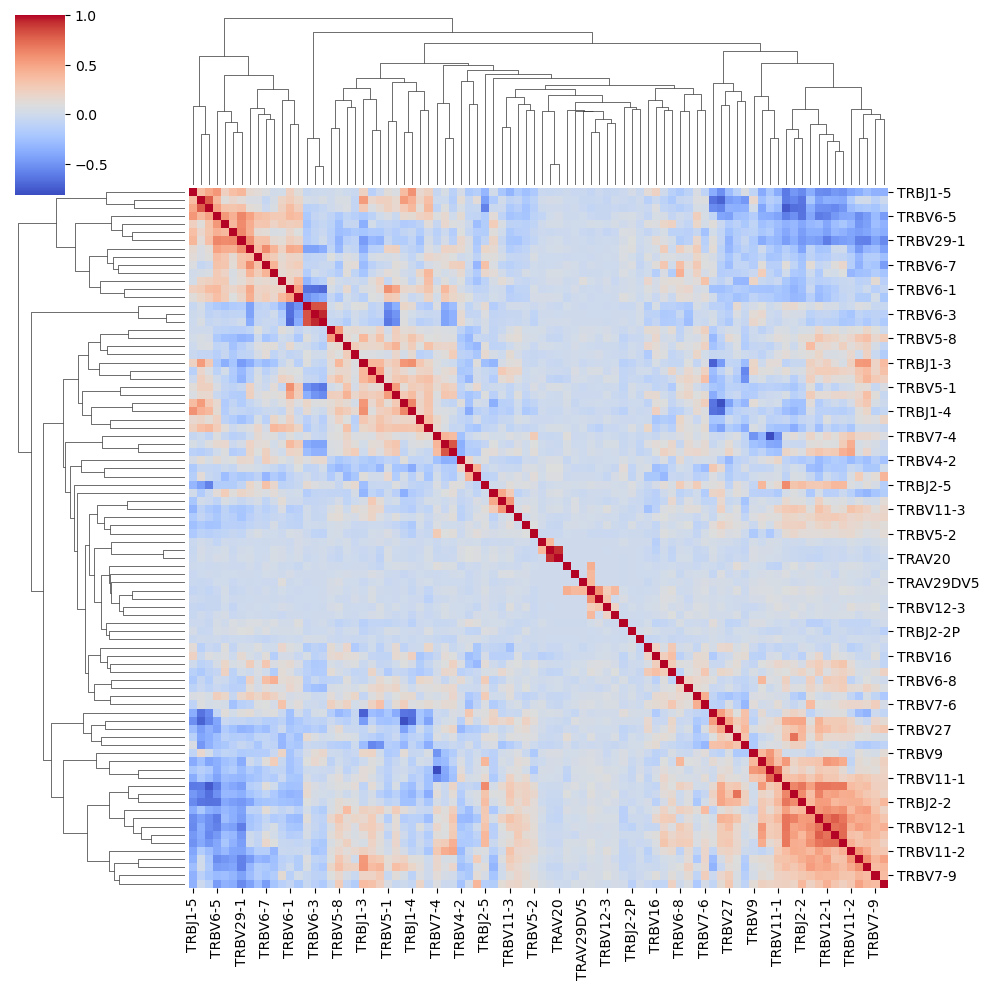

In [46]:
v_j_merged_0 = pd.concat([df_j_norm_0.drop(['id'], axis=1), df_v_norm_0.drop(['id'], axis=1)], axis=1)

corr_v_j_matrix_0 = v_j_merged_0.corr()
sns.clustermap(corr_v_j_matrix_0, cmap= 'coolwarm') 

plt.show()

# J genes usage for each patient

Without normalization first

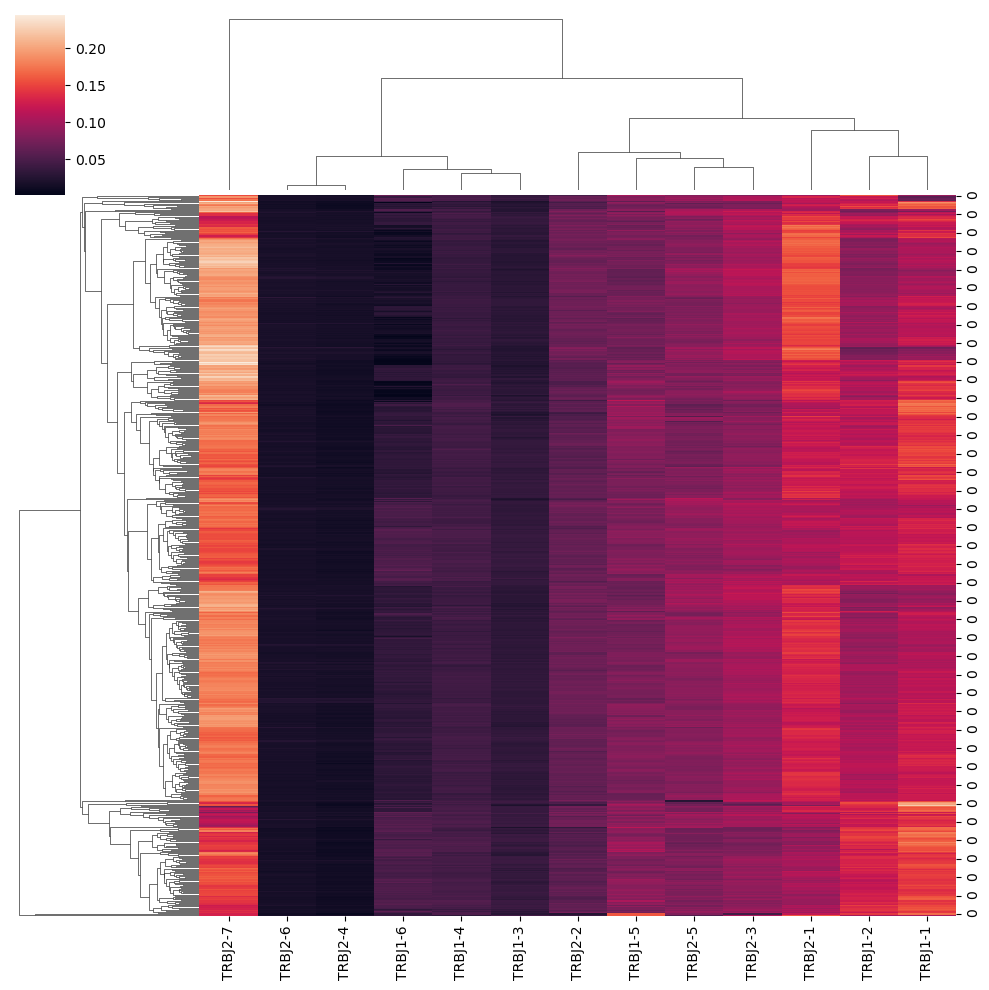

In [261]:
sns.clustermap(df_j_norm_no_na.drop(['id'], axis=1));

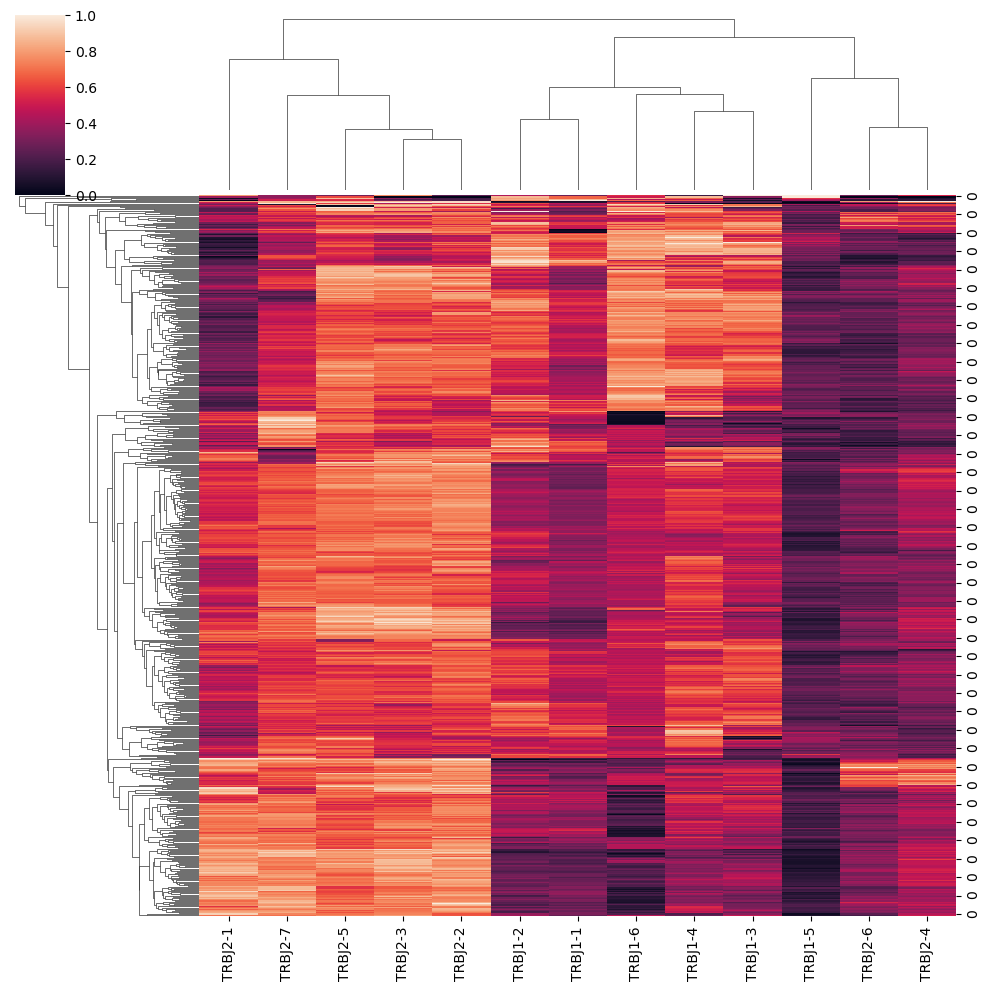

In [262]:
sns.clustermap(df_j_norm_no_na.drop(['id'], axis=1), standard_scale=1);

With normalization on maximum:

In [251]:
df_j_norm_no_na_max = df_j_norm_no_na.drop(['id'], axis=1).copy()

for column in df_j_norm_no_na_max.columns:
    df_j_norm_no_na_max[column] = df_j_norm_no_na_max[column] / df_j_norm_no_na_max[column].max()
df_j_norm_no_na_max

,TRBJ2-7,TRBJ2-6,TRBJ2-5,TRBJ2-4,TRBJ2-3,TRBJ2-2,TRBJ2-1,TRBJ1-6,TRBJ1-5,TRBJ1-4,TRBJ1-3,TRBJ1-2,TRBJ1-1
0,0.751624,0.514961,0.755760,0.439293,0.782430,0.841729,0.679489,0.433506,0.515775,0.779539,0.700079,0.655727,0.552033
0,0.835239,0.555087,0.677141,0.528062,0.732598,0.826642,0.770756,0.184631,0.492268,0.757132,0.675409,0.650701,0.547164
0,0.622969,0.485904,0.724905,0.461524,0.800023,0.777005,0.599954,0.693057,0.436318,0.760489,0.748779,0.820396,0.647978
0,0.667740,0.616264,0.709600,0.368348,0.692228,0.731818,0.621271,0.480806,0.500763,0.799968,0.741621,0.821529,0.667563
0,0.775119,0.565077,0.736863,0.543528,0.752277,0.857352,0.754673,0.547335,0.483967,0.733871,0.686396,0.609654,0.501170
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.819699,0.604204,0.718154,0.531696,0.864752,0.840028,0.846118,0.177576,0.446661,0.702828,0.631704,0.586467,0.499693
0,0.740642,0.561109,0.810962,0.612640,0.856018,0.867493,0.757927,0.535400,0.462142,0.718530,0.713054,0.611531,0.445701
0,0.519426,0.478094,0.661519,0.409213,0.709863,0.741062,0.572313,0.763933,0.567245,0.909529,0.914489,0.856358,0.676925
0,0.801193,0.833346,0.727454,0.825498,0.793130,0.790310,0.846820,0.290648,0.443605,0.696306,0.680111,0.576199,0.471312


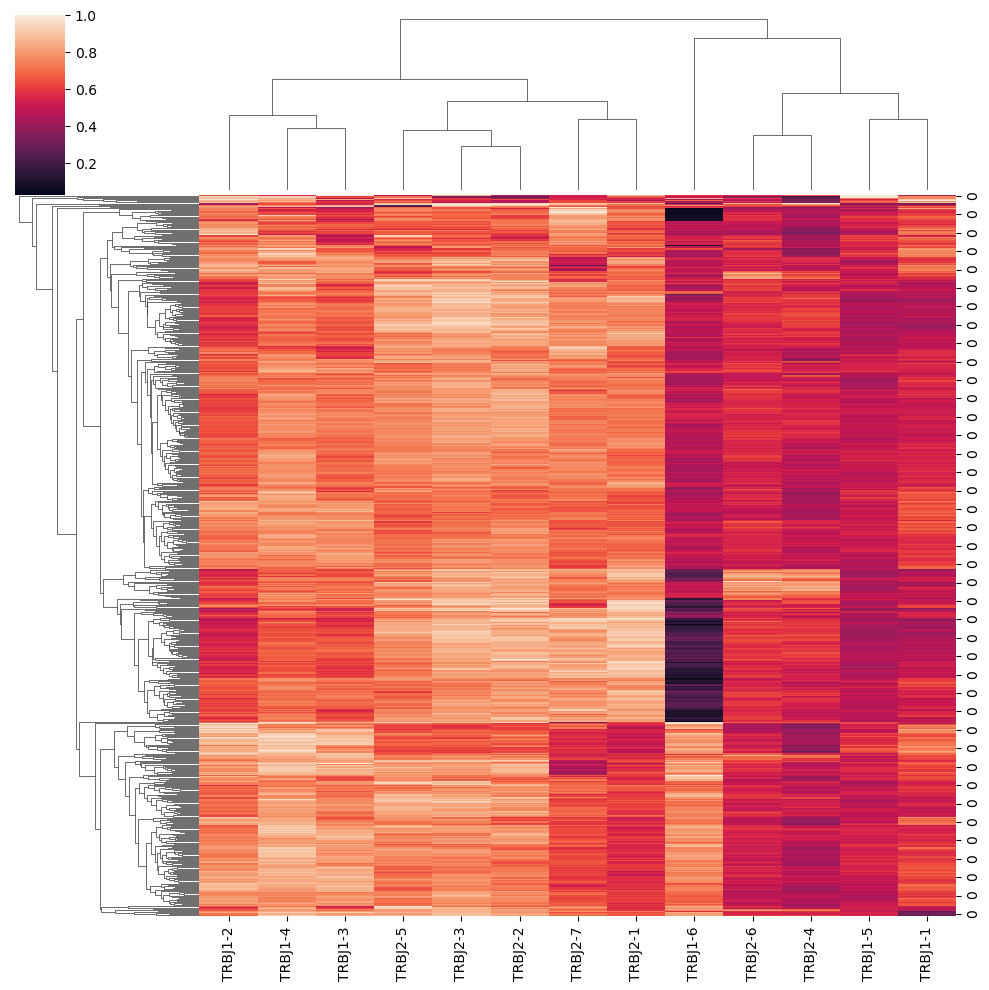

In [252]:
sns.clustermap(df_j_norm_no_na_max)

In [47]:
# нормировка на максимальное значение
df_j_norm_0_max = df_j_norm_0.drop(['id'], axis=1).copy()

for column in df_j_norm_0_max.columns:
    df_j_norm_0_max[column] = df_j_norm_0_max[column] / df_j_norm_0_max[column].max()
df_j_norm_0_max

,TRBJ2-7,TRBJ2-6,TRBJ2-5,TRBJ2-4,TRBJ2-3,TRBJ2-2P,TRBJ2-2,TRBJ2-1,TRBJ1-6,TRBJ1-5,TRBJ1-4,TRBJ1-3,TRBJ1-2,TRBJ1-1,TRAJ52,TRAJ4
0,0.751624,0.514961,0.755760,0.439293,0.782430,0.000000,0.841729,0.679489,0.433506,0.515775,0.779539,0.700079,0.655727,0.552033,0.0,0.0
0,0.835239,0.555087,0.677141,0.528062,0.732598,0.000000,0.826642,0.770756,0.184631,0.492268,0.757132,0.675409,0.650701,0.547164,0.0,0.0
0,0.622969,0.485904,0.724905,0.461524,0.800023,0.189178,0.777005,0.599954,0.693057,0.436318,0.760489,0.748779,0.820396,0.647978,0.0,0.0
0,0.667740,0.616264,0.709600,0.368348,0.692228,0.000000,0.731818,0.621271,0.480806,0.500763,0.799968,0.741621,0.821529,0.667563,0.0,0.0
0,0.775119,0.565077,0.736863,0.543528,0.752277,0.000000,0.857352,0.754673,0.547335,0.483967,0.733871,0.686396,0.609654,0.501170,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.819699,0.604204,0.718154,0.531696,0.864752,0.000000,0.840028,0.846118,0.177576,0.446661,0.702828,0.631704,0.586467,0.499693,0.0,0.0
0,0.740642,0.561109,0.810962,0.612640,0.856018,0.000000,0.867493,0.757927,0.535400,0.462142,0.718530,0.713054,0.611531,0.445701,0.0,1.0
0,0.519426,0.478094,0.661519,0.409213,0.709863,0.000000,0.741062,0.572313,0.763933,0.567245,0.909529,0.914489,0.856358,0.676925,0.0,0.0
0,0.801193,0.833346,0.727454,0.825498,0.793130,0.000000,0.790310,0.846820,0.290648,0.443605,0.696306,0.680111,0.576199,0.471312,0.0,0.0


/home/svinogradova/.conda/envs/haplotypes/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/svinogradova/.conda/envs/haplotypes/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


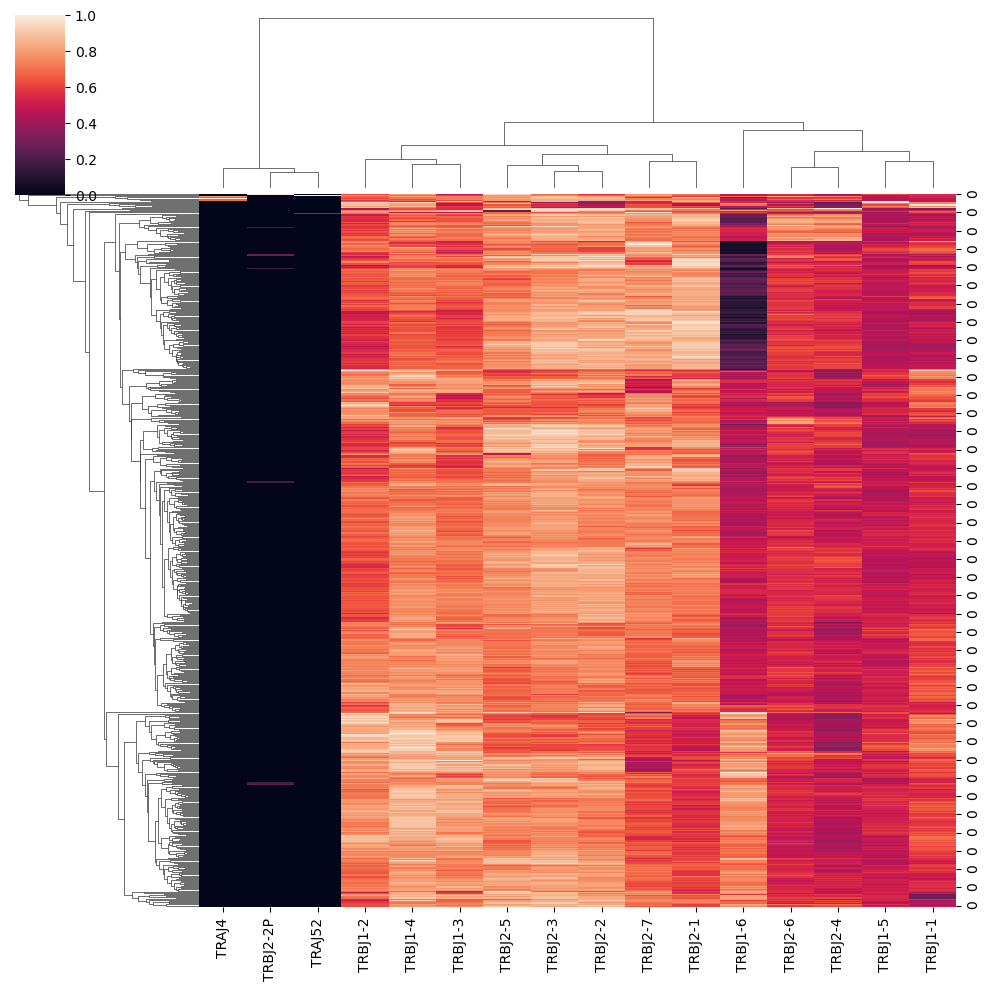

In [48]:
sns.clustermap(df_j_norm_0_max)

In [49]:
# нормировка на максимальное значение
df_v_norm_0_max = df_v_norm_0.drop(['id'], axis=1).copy()

for column in df_v_norm_0_max.columns:
    df_v_norm_0_max[column] = df_v_norm_0_max[column] / df_v_norm_0_max[column].max()
df_v_norm_0_max

,TRBV9,TRBV8-2,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,...,TRBV10-2,TRBV10-1,TRBV1,TRAV9-2,TRAV9-1,TRAV3,TRAV29DV5,TRAV23DV6,TRAV20,TRAV14DV4
0,0.683869,0.007219,0.589716,0.957840,0.557182,0.696443,0.495166,0.506187,0.397748,0.420372,...,0.550957,0.565472,0.343386,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.667794,0.012960,0.729987,0.481205,0.461967,0.589703,0.494488,0.110414,0.662144,0.408458,...,0.624006,0.768434,0.398834,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.849183,0.000000,0.666366,0.498503,0.521412,0.751380,0.561151,0.191880,0.605020,0.426070,...,0.623299,0.656851,0.340579,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.503178,0.000000,0.659946,0.439359,0.500576,0.586243,0.413389,0.420085,0.248414,0.583744,...,0.653571,0.604863,0.271739,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.698807,0.072335,0.616467,0.485557,0.507860,0.633674,0.502839,0.171293,0.574393,0.474344,...,0.463907,0.515776,0.276316,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.505246,0.006400,0.577077,0.426082,0.482044,0.606415,0.597145,0.487608,0.424872,0.442768,...,0.787442,0.744038,0.322942,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.783395,0.000000,0.703855,0.540144,0.635034,0.747646,0.681814,0.211083,1.000000,0.474853,...,0.404233,0.625520,0.287042,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.774165,0.000000,0.740019,0.519979,0.519430,0.733118,0.400354,0.142573,0.764373,0.646564,...,0.232423,0.342590,0.183159,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.568235,0.010321,0.851918,0.300463,0.395903,0.579828,0.494280,0.501591,0.390329,0.600110,...,0.654897,0.704699,0.295072,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/home/svinogradova/.conda/envs/haplotypes/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/svinogradova/.conda/envs/haplotypes/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


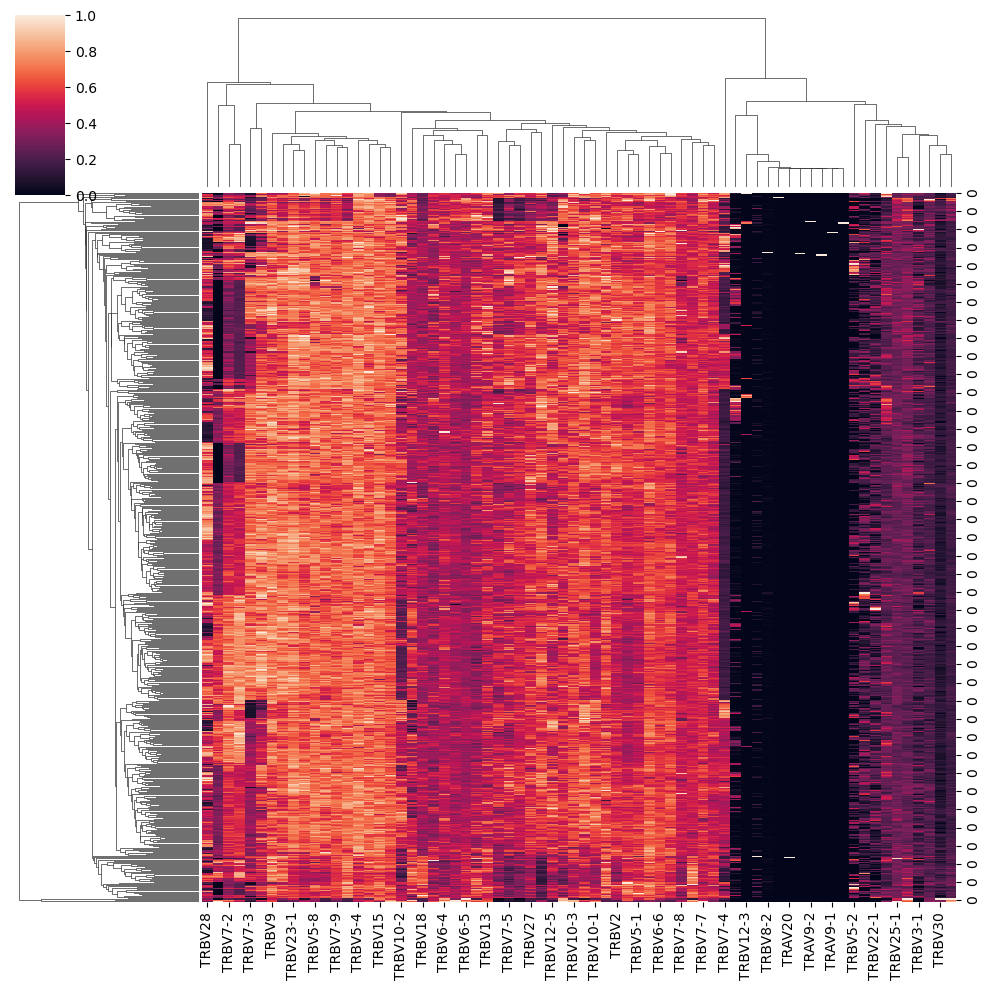

In [50]:
sns.clustermap(df_v_norm_0_max)

/home/svinogradova/.conda/envs/haplotypes/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/svinogradova/.conda/envs/haplotypes/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


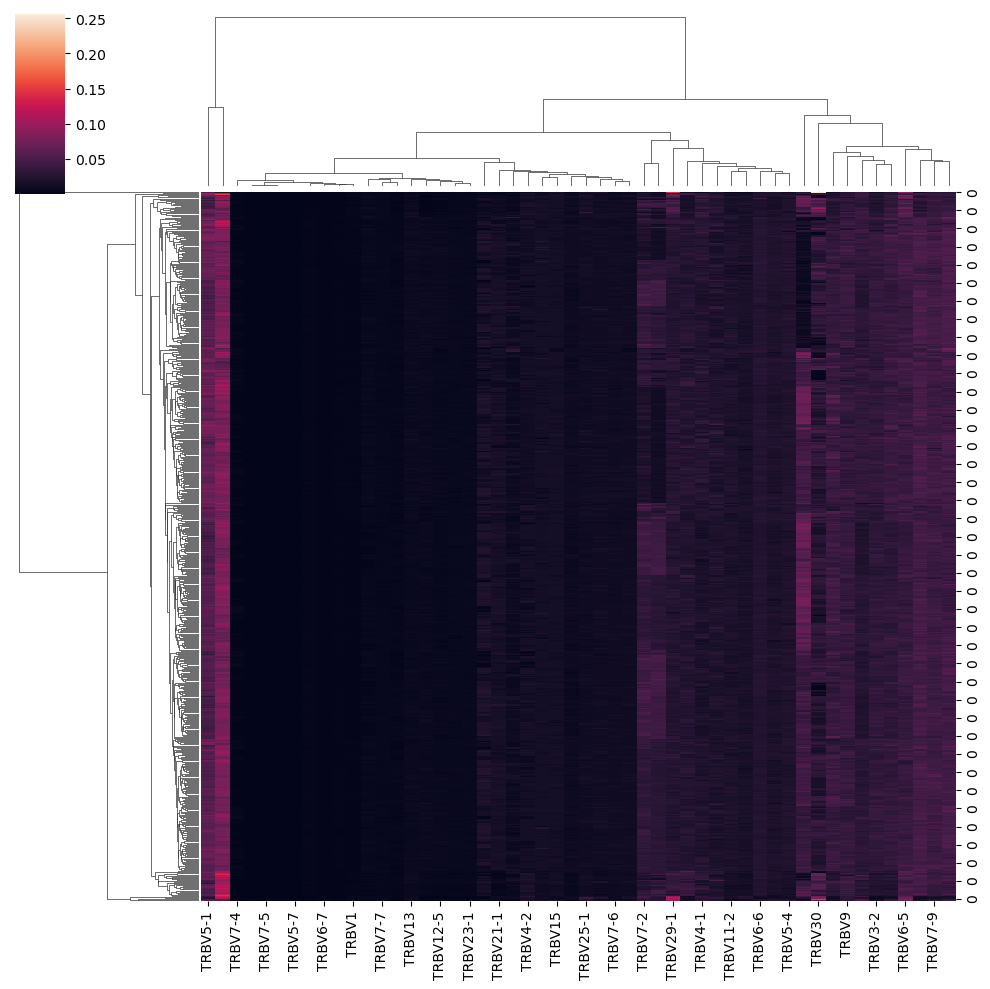

In [235]:
sns.clustermap(df_v_norm_no_na.drop(['id'], axis=1));

Here are functions needed for further analysis.

In [3]:
def plot_hist_usage(gene_names: list, usage_matrix, n_cols: int = 5, file_name: str = None):
    """Visualise gene usage histograms
    arguments:
        - gene_names: list of gene names for visualisation
        - usage_matrix: matrix with gene usage value
        - n_cols: number of columns for pictures
        - file_name: file name for saving pictures
    """
    
    plt.figure(figsize=(10,15))
    
    n_genes = len(gene_names)
    if n_genes % n_cols != 0:
        n_rows = n_genes // n_cols + 1 
    else: 
        n_rows = n_genes // n_cols 
    
    for i, column in enumerate(gene_names):
        plt.subplot(n_rows, n_cols, i+1)
        plt.hist(x=usage_matrix[column], bins=100)
        plt.title(f'{column}') 
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();

In [4]:
def plot_hist_of_vs_nf(gene_names: list, of_usage_matrix, nf_usage_matrix, n_cols: int = 5, file_name: str = None):
    """Visualise joint distributions of only functional and nonfunctional sequences gene usage histograms
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - n_cols: number of columns for pictures
        - file_name: file name for saving pictures
    """
    
    plt.figure(figsize=(20,30))
    
    n_genes = len(gene_names)
    if n_genes % n_cols != 0:
        n_rows = n_genes // n_cols + 1 
    else: 
        n_rows = n_genes // n_cols 

    for i, column in enumerate(gene_names):
        plt.subplot(n_rows, n_cols, i+1)
        plt.hist(x=of_usage_matrix[column], bins=50, alpha=0.9, label='of')#blue
        plt.hist(x=nf_usage_matrix[column], bins=50, alpha=0.3, label='nf')#yellow
        plt.title(f'{column}')
        plt.legend(fontsize="9")
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();

In [5]:
def plot_scatter_of_vs_nf(gene_names: list, of_usage_matrix, nf_usage_matrix, file_name = None, clonotype_counts = None):
    """Visualise and calculate regression coefficients of scatterplots for only functional and nonfunctional sequences gene usage
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - file_name: file name for saving pictures
        - clonotype_counts: file name for saving clonotype counts dict
    return:
        - regression coefficients 
    """
    
    tr_fit_koef = pd.DataFrame(columns=['gene', 'koef'])

    plt.figure(figsize=(20,30))

    for i, column in enumerate(gene_names):
        x = of_usage_matrix[column]
        y = nf_usage_matrix[column]
        plt.subplot(len(gene_names) // 5 + 1, 5, i+1)

        plt.scatter(x=x, y=y, s=1)
        lim = max(plt.ylim()[1], plt.xlim()[1])
        xy_lim = (0, lim)
        plt.plot(xy_lim, xy_lim, color = 'r', label='y=x')

        x = np.array(x)
        y = np.array(y)
        x = np.append(x, [0])
        y = np.append(y, [0])
        x = np.array(x)[:,np.newaxis]
        a, _, _, _ = np.linalg.lstsq(x, y)
        plt.plot(x, a*x, 'blue', label='regression')
        tr_fit_koef.loc[i] = [column, a[0]] 

        plt.text(xy_lim[1]-0.8*xy_lim[1], 0, f'k={float(a):.2f}', fontsize=10)
        if clonotype_counts is not None:
            clonotype_count_dict = np.load(clonotype_counts,allow_pickle='TRUE').item()
            plt.text(xy_lim[1]-0.8*xy_lim[1], 0.15*xy_lim[1], f'%={float(clonotype_count_dict[column]):.2f}', fontsize=10)
        
        plt.title(f'{column}') 
        plt.xlabel("of usage")
        plt.ylabel("nf usage")
        plt.legend(fontsize="8")
    plt.subplots_adjust(wspace=0.4, hspace=0.8)
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    plt.show();
    
    return tr_fit_koef

In [7]:
def calculate_p_value_ks_test(gene_names: list, of_usage_matrix, nf_usage_matrix, adj_bonf: bool = False)->dict:
    """Kolmogorov-Smirnov test calculation for gene-usage of nonfunctional and only functional sequences
    arguments:
        - gene_names: list of gene names for visualisation
        - of_usage_matrix: matrix with gene usage value for only functional sequences
        - nf_usage_matrix: matrix with gene usage value for nonfunctional sequences
        - adj_bonf: if bonferrony adjastment for p-value is necessary
    return:
        - dictionary with p-value for each gene
    """
    
    p_value_dict = {}
    
    for gene in gene_names:
        p_value_dict[gene] = stats.ks_2samp(nf_usage_matrix[gene], of_usage_matrix[gene]).pvalue
        
    if adj_bonf:
        adj = len(p_value_dict)
        for k, v in p_value_dict.items():
            p_value_dict[k] = v * adj
            if p_value_dict[k] > 1:
                p_value_dict[k] = 1
        
    return p_value_dict

# Beta chain: Nonfunctional vs Onlyfunctional sequences

No analysis was done for alpha chain at all due to bad results of sequencing.

In [31]:
#nonfunc TRB-V
nf_trbv_matrix = pd.read_csv('../data/cohort_II/nonfunctional_corrected/nf_trbv_hip_norm.csv').drop(['Unnamed: 0'], axis=1)
nf_trbv_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
nf_trbv_matrix.head(3)

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-5,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-9,...,TRBV12-2,TRBV12-1,TRBV11-3,TRBV11-2,TRBV11-1,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,id
0,0.028406,0.032141,0.013968,0.007204,0.009259,0.002841,0.017420,0.023761,0.012398,0.002919,...,0.008914,0.004300,0.012210,0.012210,0.002998,0.016353,0.004143,0.024639,0.008789,HIP14174.txt
1,0.034543,0.029873,0.007659,0.006164,0.007386,0.002658,0.004224,0.032330,0.014886,0.002471,...,0.007932,0.003908,0.011581,0.018004,0.003563,0.017185,0.005604,0.026870,0.010245,HIP13142.txt
2,0.034879,0.029992,0.007768,0.007579,0.009997,0.002847,0.006842,0.033233,0.015433,0.003018,...,0.008368,0.004098,0.018194,0.015793,0.003618,0.014782,0.005865,0.023493,0.008728,HIP02928.txt


In [32]:
#onlyfunc TRB-V
of_trbv_matrix = pd.read_csv('../data/cohort_II/onlyfunctional_corrected/of_trbv_hip_norm.csv').drop(['Unnamed: 0'], axis=1)
of_trbv_matrix.rename(columns=lambda x: x.split("*")[0], inplace=True)
of_trbv_matrix.head(3)

,TRBV9,TRBV7-9,TRBV7-8,TRBV7-7,TRBV7-6,TRBV7-4,TRBV7-3,TRBV7-2,TRBV6-6,TRBV6-5,...,TRBV13,TRBV12-5,TRBV12-4,TRBV11-3,TRBV11-2,TRBV10-3,TRBV10-2,TRBV10-1,TRBV1,id
0,0.037347,0.039373,0.029327,0.003782,0.011192,0.000920,0.009024,0.028995,0.025907,0.041859,...,0.007220,0.005844,0.049273,0.004592,0.016711,0.018058,0.005965,0.004935,0.000774,HIP14174.txt
1,0.034356,0.050176,0.014332,0.003058,0.009427,0.000119,0.016520,0.027039,0.022154,0.031767,...,0.006267,0.005114,0.044021,0.004031,0.021816,0.016934,0.006440,0.008204,0.000919,HIP13142.txt
2,0.046723,0.046217,0.015232,0.003361,0.012140,0.000293,0.014477,0.028881,0.028733,0.048526,...,0.012336,0.006337,0.055703,0.006489,0.024243,0.012385,0.006510,0.006959,0.000767,HIP02928.txt


In [33]:
ids = set(nf_trbv_matrix.id).intersection(set(of_trbv_matrix.id))
nf_trbv_matrix = nf_trbv_matrix[nf_trbv_matrix.id.isin(ids)].drop(['id'], axis=1)
of_trbv_matrix = of_trbv_matrix[of_trbv_matrix.id.isin(ids)].drop(['id'], axis=1)


v_gene_names_set_b = set(nf_trbv_matrix.columns).intersection(set(of_trbv_matrix.columns)) 

v_gene_names_set_b = list(v_gene_names_set_b)
v_gene_names_set_b.sort()

## Gene usage on population scale histograms

### Nonfunctional

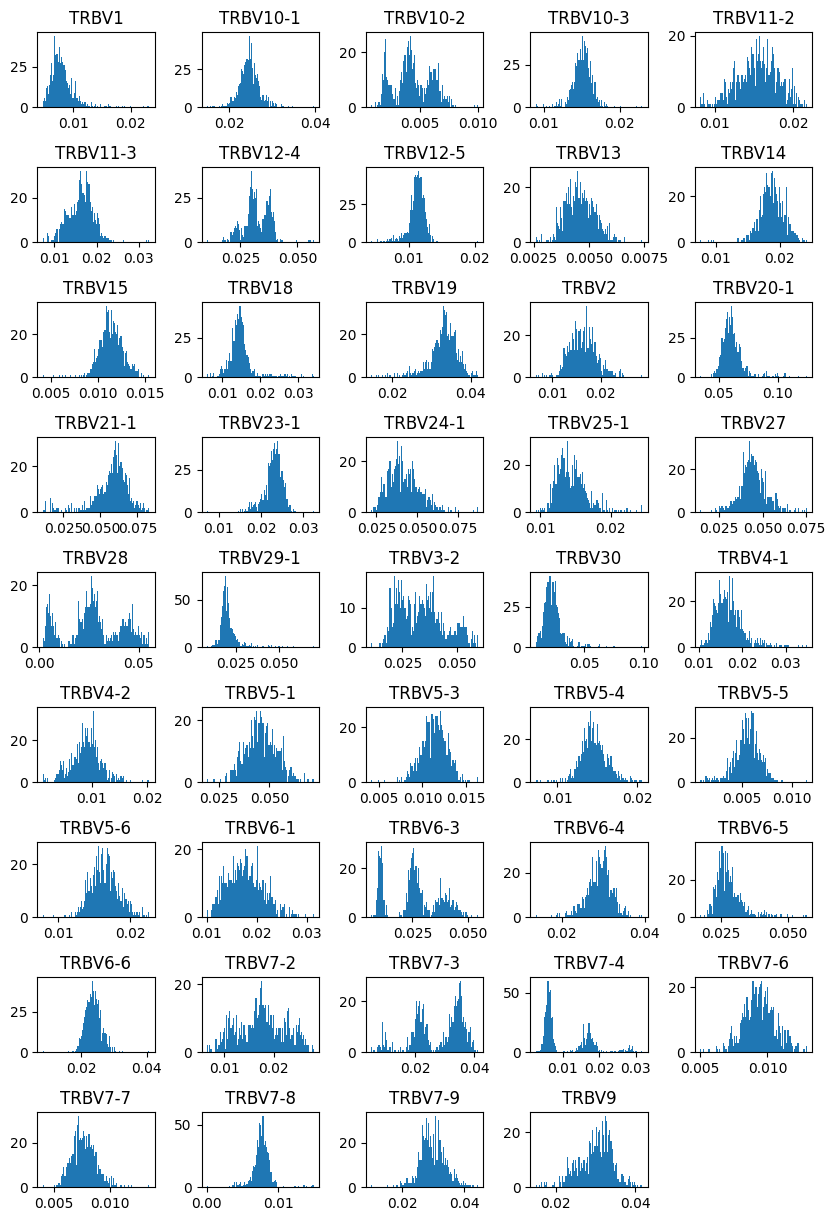

In [34]:
#nonfunc TRB-V
plot_hist_usage(v_gene_names_set_b, nf_trbv_matrix)

### Onlyfunctional

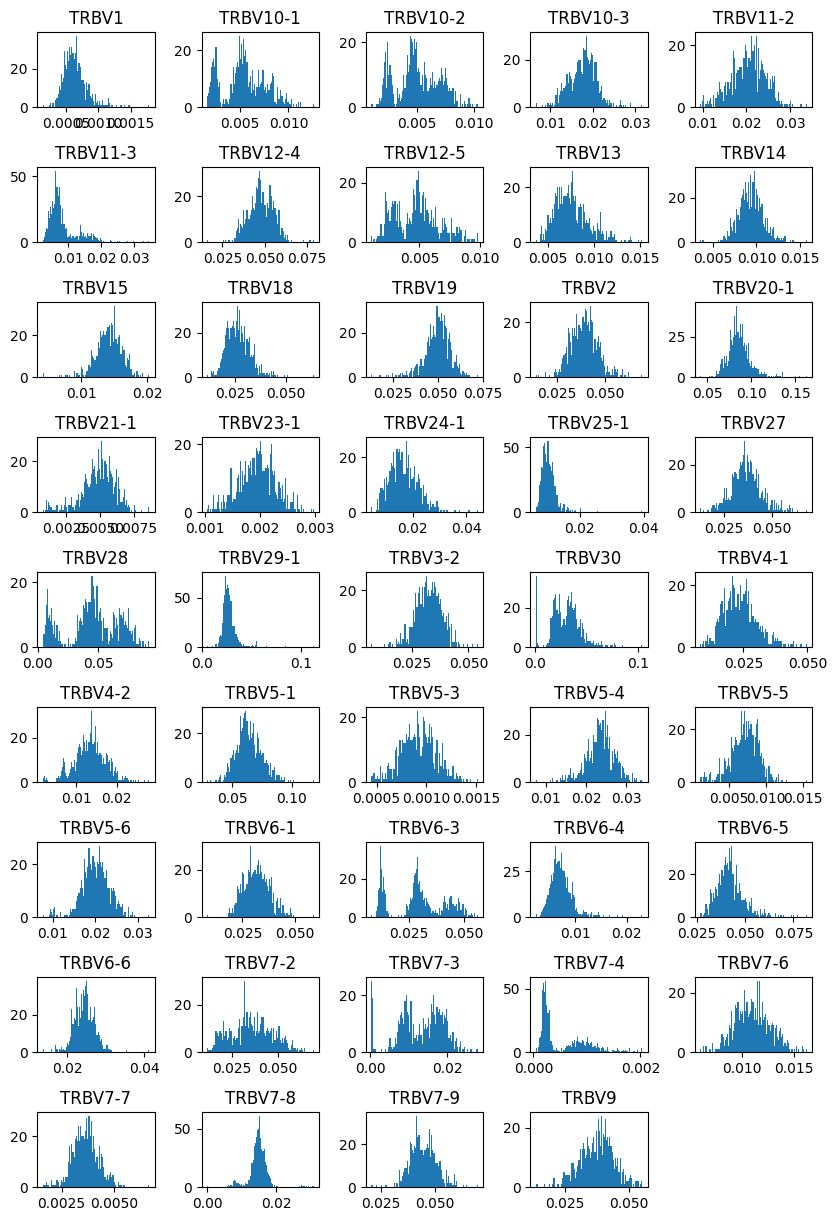

In [35]:
#onlyfunc TRB-V
plot_hist_usage(v_gene_names_set_b, of_trbv_matrix)

## Joint histograms (Nonfunctional vs Onlyfunctional)

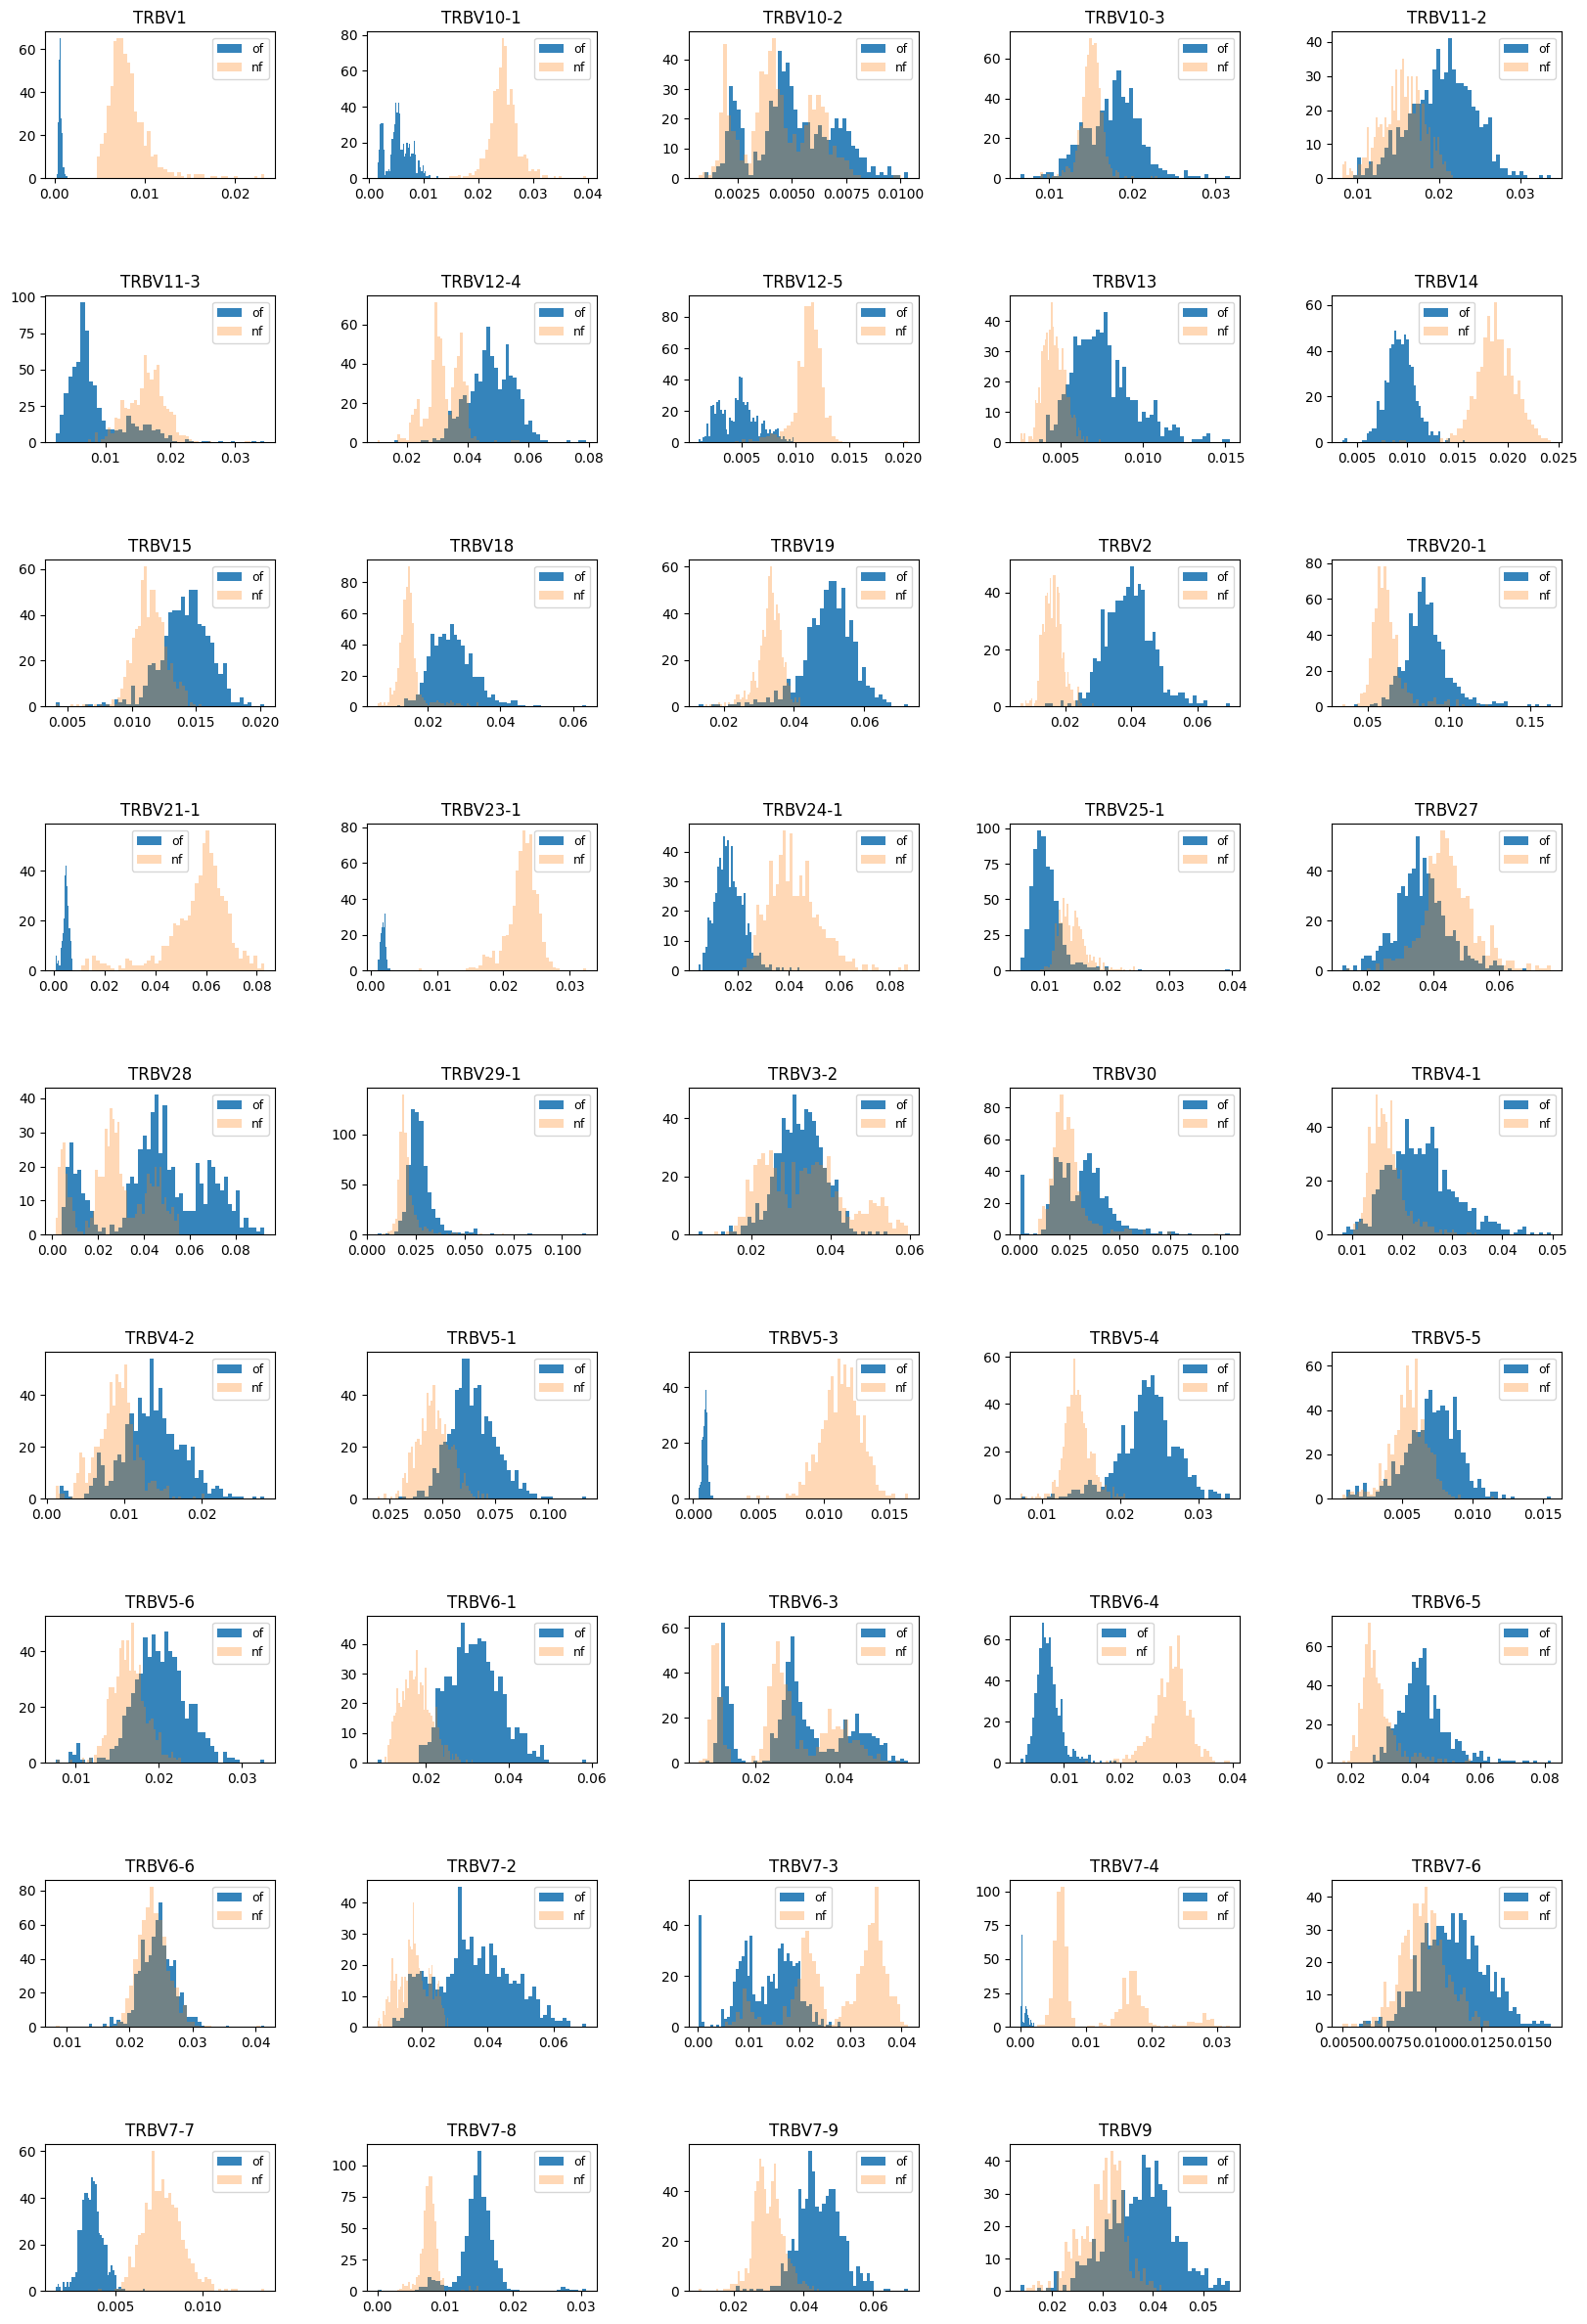

In [36]:
#onlyfunc и nonfunc TRB-V
plot_hist_of_vs_nf(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix)

### Kolmogorov-Smirnov test for nf vs of

In [37]:
#TRB-V
trbv_ks_test_p_values = calculate_p_value_ks_test(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix, True)
trbv_sign = {key: val for key, val in trbv_ks_test_p_values.items() if val <= 0.05}
trbv_sign

{'TRBV1': 0.0,
 'TRBV10-1': 0.0,
 'TRBV10-2': 9.520814123324601e-12,
 'TRBV10-3': 6.03867157009733e-98,
 'TRBV11-2': 3.281211903513203e-100,
 'TRBV11-3': 1.2946189875646063e-179,
 'TRBV12-4': 8.115303433430273e-218,
 'TRBV12-5': 1.36045109405571e-309,
 'TRBV13': 8.60262774302742e-220,
 'TRBV14': 0.0,
 'TRBV15': 1.0887892315900754e-141,
 'TRBV18': 4.057112671189272e-257,
 'TRBV19': 2.9060770822589544e-281,
 'TRBV2': 0.0,
 'TRBV20-1': 5.517880304248441e-212,
 'TRBV21-1': 0.0,
 'TRBV23-1': 0.0,
 'TRBV24-1': 5.936270216e-314,
 'TRBV25-1': 5.262378884182798e-183,
 'TRBV27': 1.1606212459546874e-62,
 'TRBV28': 2.0513955154348e-64,
 'TRBV29-1': 1.2859498672551648e-126,
 'TRBV3-2': 5.6735427256004054e-08,
 'TRBV30': 1.3426417864098733e-42,
 'TRBV4-1': 2.878620973910619e-96,
 'TRBV4-2': 8.808622559766988e-101,
 'TRBV5-1': 6.9857114079716475e-152,
 'TRBV5-3': 0.0,
 'TRBV5-4': 1.5502162779566078e-282,
 'TRBV5-5': 1.5136587933621362e-67,
 'TRBV5-6': 2.1993477507933433e-97,
 'TRBV6-1': 5.59732982837

## Scatterplots (Nonfunctional vs Onlyfunctional)

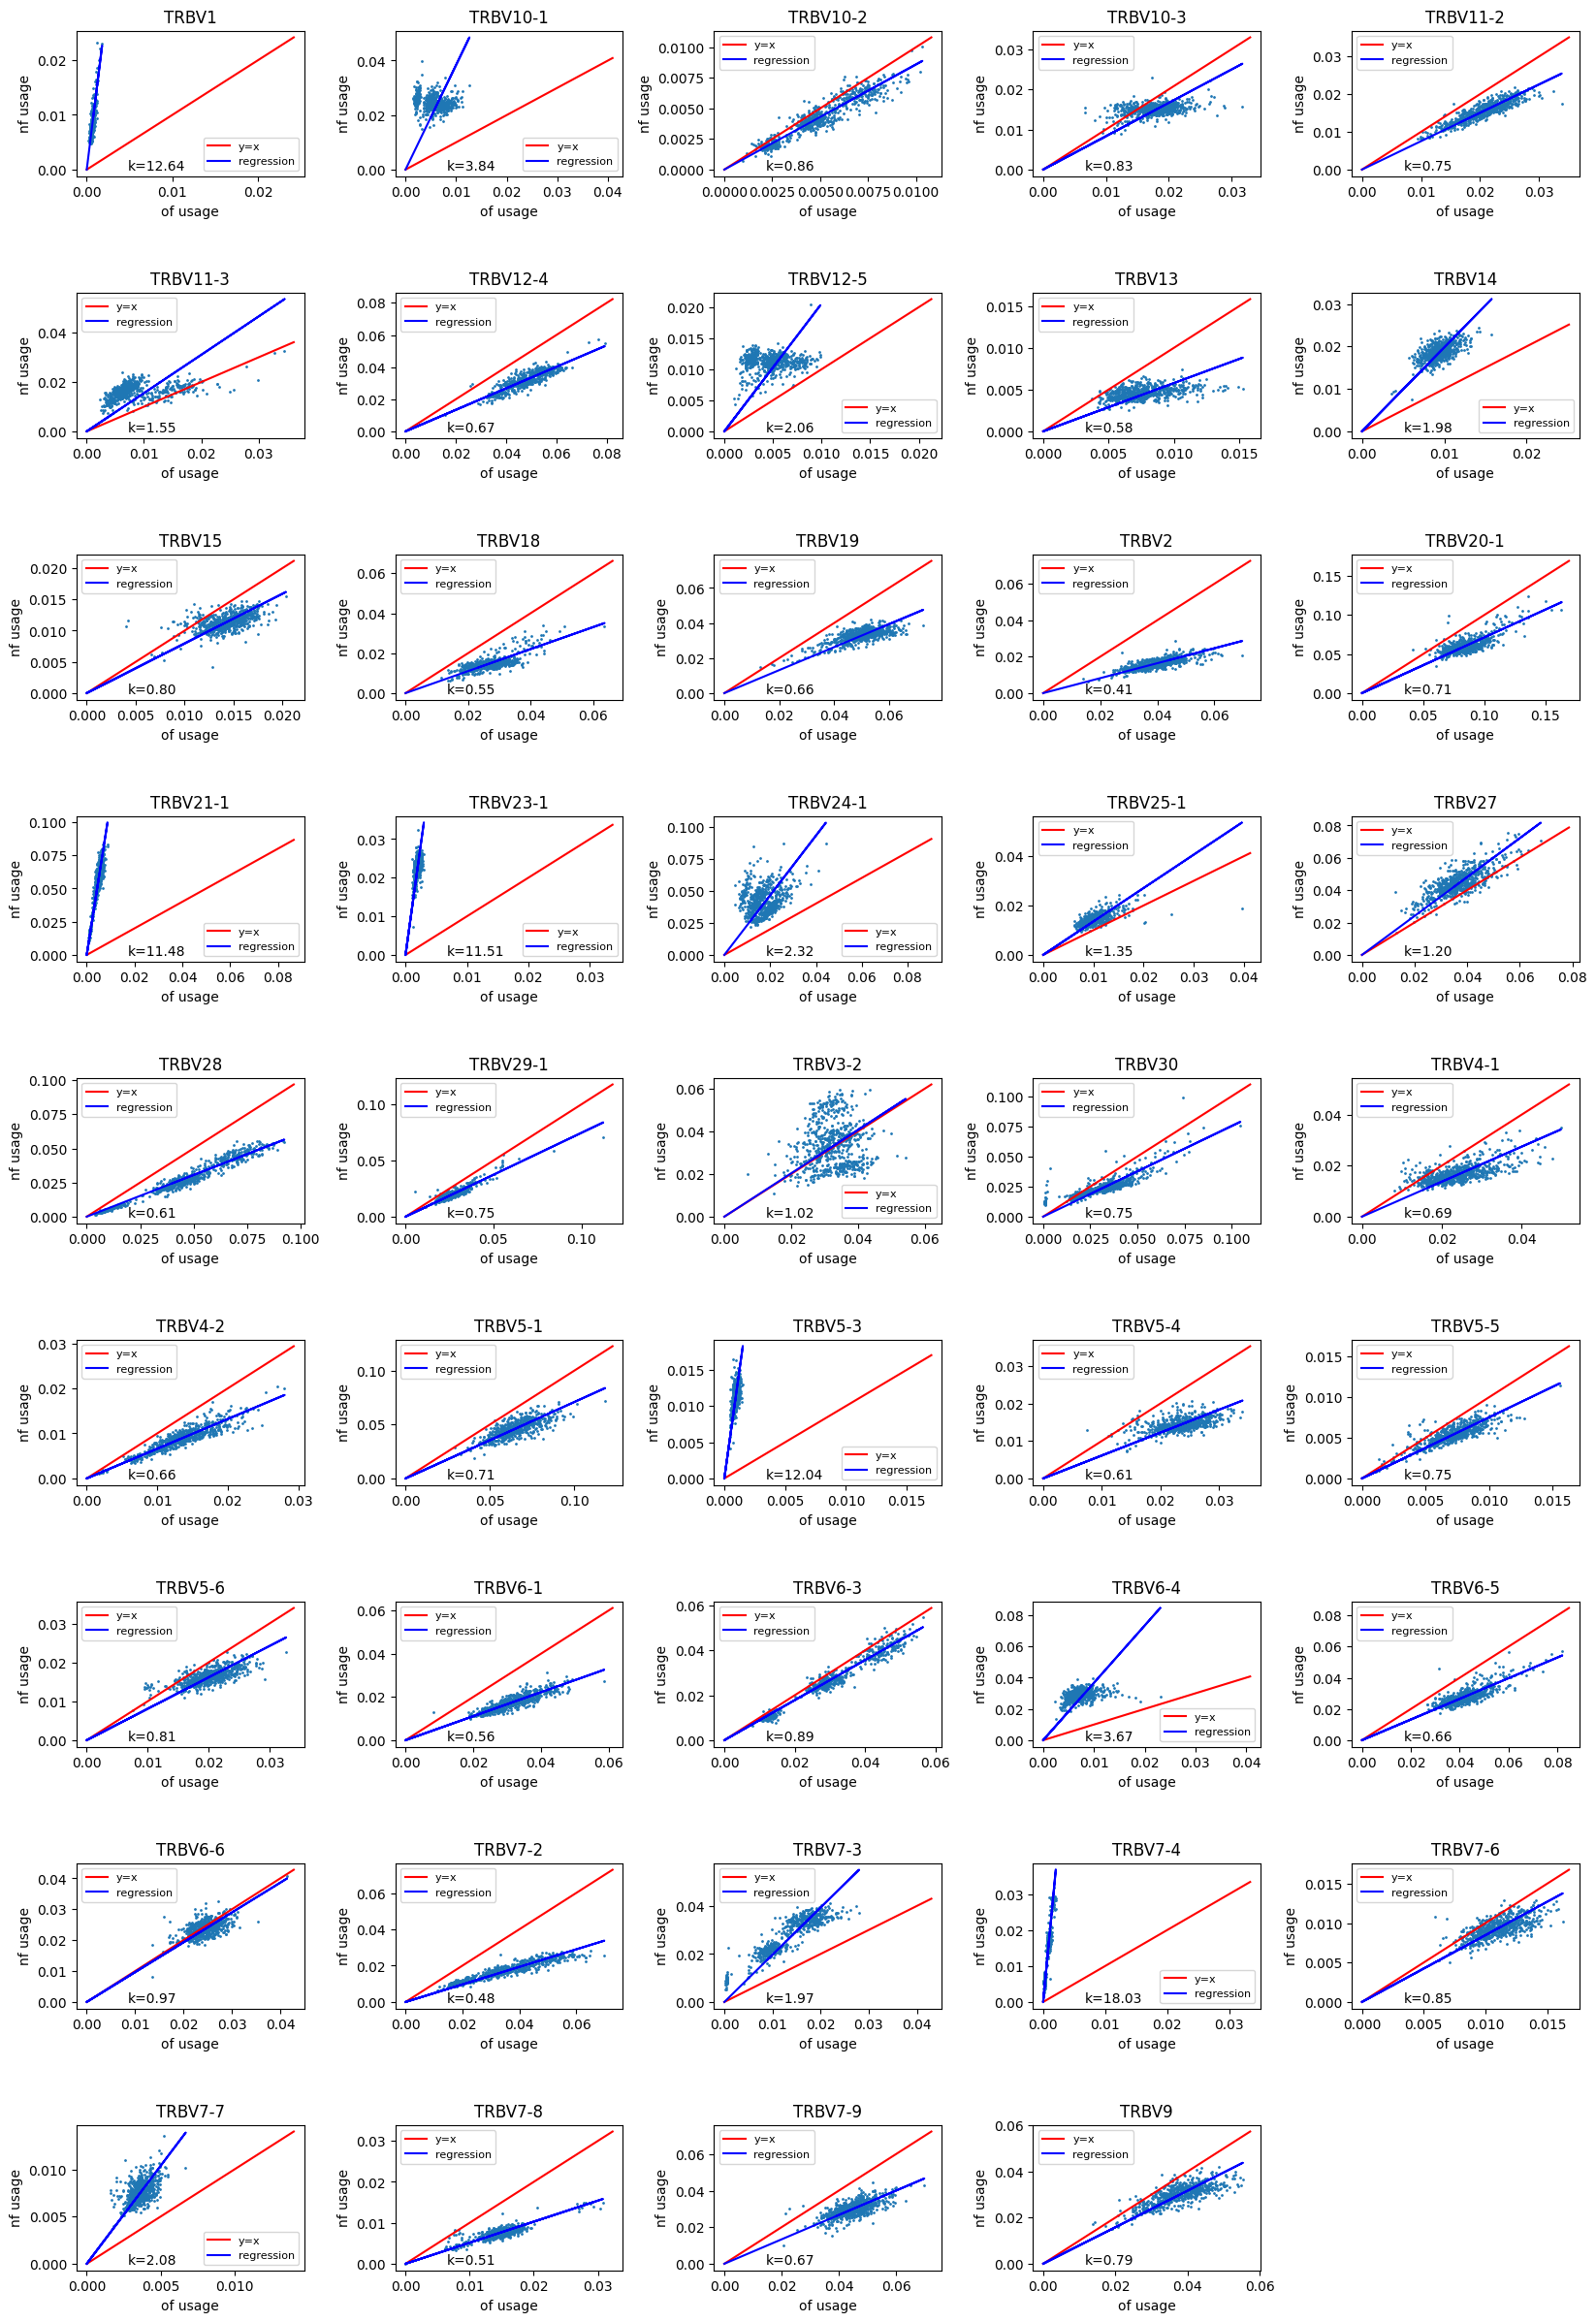

In [41]:
trbv_fit_koef = plot_scatter_of_vs_nf(v_gene_names_set_b, of_trbv_matrix, nf_trbv_matrix)

In [42]:
trbv_fit_koef

,gene,koef
0,TRBV1,12.641298
1,TRBV10-1,3.841228
2,TRBV10-2,0.859048
3,TRBV10-3,0.831924
4,TRBV11-2,0.752764
5,TRBV11-3,1.552084
6,TRBV12-4,0.669642
7,TRBV12-5,2.055995
8,TRBV13,0.578170
9,TRBV14,1.978018


In [43]:
trbv_pseudo = ['TRBV12-1', 'TRBV12-2', 'TRBV21-1', 'TRBV3-2', 'TRBV7-5']

print('--Mean calculation--')
print(f'For full set of genes (total {len(trbv_fit_koef)} genes)  \t{round(np.mean(trbv_fit_koef.koef), 2)} \u00B1 {round(np.std(trbv_fit_koef.koef), 2)}')
print(f'Without preudogenes (total {len(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)])} genes) \t\t {round(np.mean(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)} \u00B1 {round(np.std(trbv_fit_koef[~trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)}')
print(f'Only pseudogenes (total {len(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)])} genes) \t\t {round(np.mean(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)} \u00B1 {round(np.std(trbv_fit_koef[trbv_fit_koef["gene"].isin(trbv_pseudo)].koef), 2)}')

--Mean calculation--
For full set of genes (total 44 genes)  	2.46 ± 3.98
Without preudogenes (total 42 genes) 		 2.28 ± 3.82
Only pseudogenes (total 2 genes) 		 6.25 ± 5.23
